# Time Series Forecasting Using Deep Learning

In [367]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError

Let's say we have 12,285 rows of data (time series points)

- Data Window: A set of input to train the output, used for time series -> 24 data points ts to forward predict the next 24 data points of ts
- Batch: A set of data windows, grouped together to train the model -> 32 time data windows collected in one batch, so batch size would be 384 batches
- Epoch: One set of training all the batch, but to improve the accuracy, we will train as many epochs as possible, using shuffling
- Shuffling: Shuffle the data at batch level, to improve the accuracy of the model and make the model robust

## # 1 Data Loading

In [78]:
df = pd.read_csv('/Users/taufiqurrohman/Documents/ds_marketing_portfolio/time_series/dataset/Metro_Interstate_Traffic_Volume.csv')

display(df.head(5))
df.info()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [79]:
# converting column into their corresponding data type

df['date_time'] = pd.DatetimeIndex(df['date_time'])
df['date_time'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 48204 entries, 0 to 48203
Series name: date_time
Non-Null Count  Dtype         
--------------  -----         
48204 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 376.7 KB


In [80]:
# sorting by date time column
df = df.sort_values('date_time')

In [81]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,48204.0,281.205870,13.338232,0.0,272.16,282.45,291.806,310.07
rain_1h,48204.0,0.334264,44.789133,0.0,0.00,0.00,0.000,9831.30
snow_1h,48204.0,0.000222,0.008168,0.0,0.00,0.00,0.000,0.51
clouds_all,48204.0,49.362231,39.015750,0.0,1.00,64.00,90.000,100.00
traffic_volume,48204.0,3259.818355,1986.860670,0.0,1193.00,3380.00,4933.000,7280.00


In [82]:
df.describe(include='object').T

,count,unique,top,freq
holiday,48204,12,None,48143
weather_main,48204,11,Clouds,15164
weather_description,48204,38,sky is clear,11665


In [83]:
# dropping rain_1h and snow_1h
# not needed as all values are zero

df = df.drop(['rain_1h', 'snow_1h'], axis=1)
df.columns

Index(['holiday', 'temp', 'clouds_all', 'weather_main', 'weather_description',
       'date_time', 'traffic_volume'],
      dtype='object')

## # 2 Exploratory Data Analysis (EDA)

Text(0, 0.5, 'traffic volume')

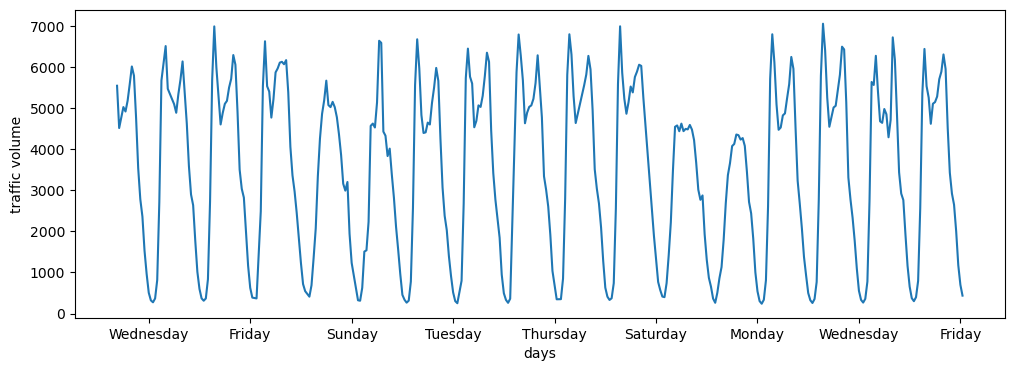

In [84]:
from matplotlib.dates import DateFormatter

# looking for the trend of TRAFFIC VOLUME ON DAILY SEASONALITY

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)  # put the figure on the ax canvas

plt.plot(df['date_time'].head(400), df['traffic_volume'].head(400))
date_form = DateFormatter("%A")
ax.xaxis.set_major_formatter(date_form)

ax.set_xlabel('days')
ax.set_ylabel('traffic volume')

Text(0, 0.5, 'temperature')

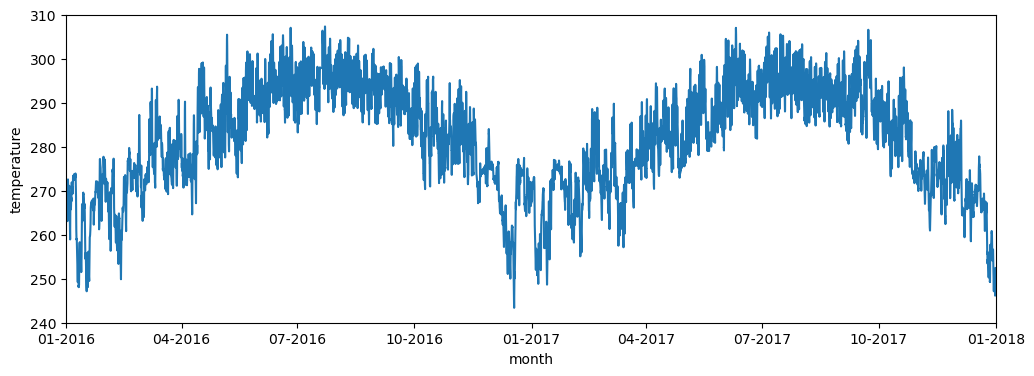

In [85]:
import datetime

# looking for the trend of TEMPERATURE OVER YEARS

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)  # put the figure on the ax canvas

plt.plot(df['date_time'], df['temp'])

ax.set_xlim([datetime.date(2016, 1, 1), datetime.date(2018, 1, 1)])
ax.set_ylim(240, 310)

date_form = DateFormatter('%m-%Y')
ax.xaxis.set_major_formatter(date_form)

ax.set_xlabel('month')
ax.set_ylabel('temperature')

Text(0, 0.5, 'temperature')

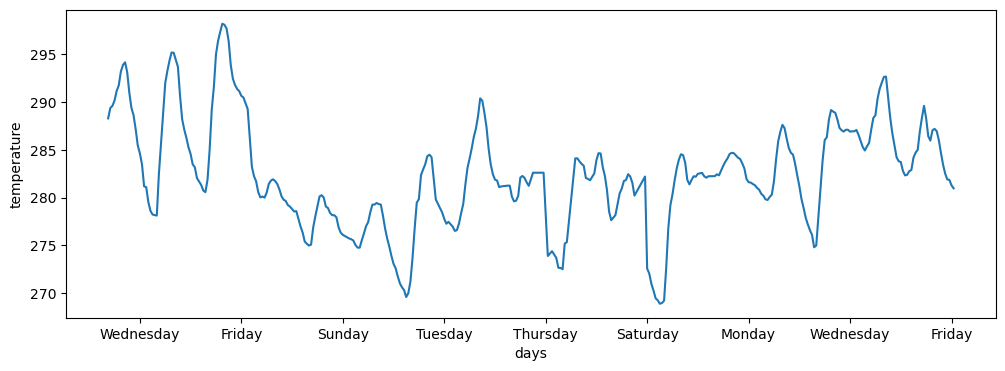

In [86]:
from matplotlib.dates import DateFormatter

# looking for the trend of TEMPRATURE SEASONALITY BY DAYS

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)  # put the figure on the ax canvas

plt.plot(df['date_time'].head(400), df['temp'].head(400))
date_form = DateFormatter("%A")
ax.xaxis.set_major_formatter(date_form)

ax.set_xlabel('days')
ax.set_ylabel('temperature')

## # 3 Data Preprocessing

    Transform timestamp so it would express a clock

In [87]:
# sine and cos transformation on time stamp
# to get timestamp in second while not losing the cyclical nature of time
# cos transformation to differentiate between 5 AM and 5 PM

timestamp_s = df['date_time'].map(datetime.datetime.timestamp)
s_in_day = 24 * 60 * 60

# formula to calculate sine and cos transformation
# don't forget to divide by the number of seconds in a day

df['day_sine'] = (np.sin(timestamp_s * (2 * np.pi/s_in_day))).values
df['day_cos'] = (np.cos(timestamp_s * (2 * np.pi/s_in_day))).values

df = df.drop('date_time', axis=1)

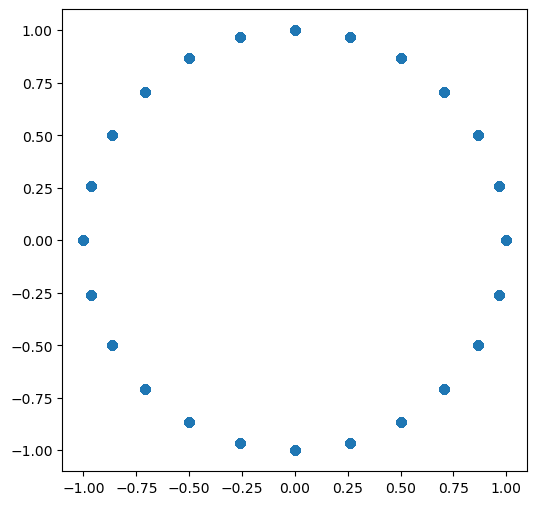

In [88]:
# final result

plt.figure(figsize=(6,6))
plt.scatter(df['day_sine'], df['day_cos'])

    Transform categorical column to number (one hot encoding)

In [89]:
from sklearn.preprocessing import OneHotEncoder

col_to_encode = ['holiday', 'weather_main', 'weather_description']

for col in col_to_encode:
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder_df = pd.DataFrame(encoder.fit_transform(df[[col]]).toarray())
    encoder_df.columns = encoder.get_feature_names_out()
    final_df = df.join(encoder_df)
    final_df.drop(col, axis=1, inplace=True)

    Final Before Moving On: Dropping Unimportant Column

In [90]:
df.value_counts(['weather_main', 'weather_description', 'clouds_all']).sort_index()

weather_main  weather_description     clouds_all
Clear         Sky is Clear            0              1726
              sky is clear            0                97
                                      1             10298
                                      2                 2
                                      3                 3
                                                    ...  
Thunderstorm  thunderstorm with rain  40                1
                                      75                8
                                      90               24
                                      92                2
                                      100               1
Length: 379, dtype: int64

In [91]:
df['holiday'].value_counts()

None                         48143
Labor Day                        7
Thanksgiving Day                 6
Christmas Day                    6
New Years Day                    6
Martin Luther King Jr Day        6
Columbus Day                     5
Veterans Day                     5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Name: holiday, dtype: int64

In [92]:
# dropping holiday and weather + its description
# not important for the model and analysis

df = df.drop(['holiday', 'weather_main', 'weather_description'], axis=1)
df.columns

Index(['temp', 'clouds_all', 'traffic_volume', 'day_sine', 'day_cos'], dtype='object')

    Train, Validation, and Test Split

In [93]:
from sklearn.model_selection import train_test_split

# splitting by train:validation:test by 70:20:10

train_r = 0.7
val_r = 0.2
test_r = 0.1

# using two-step train test split
# shuffle = False as this is time series data

train_df, test_df = train_test_split(df, test_size=1-train_r, shuffle=False)
val_df, test_df = train_test_split(test_df, test_size=test_r/(test_r + val_r), shuffle=False) 

print(len(train_df), ',', len(val_df), ',', len(test_df))

33742 , 9641 , 4821


    Scaling the Data

In [94]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df)  # only fitting the scaler to train data set to avoid data leakage

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

## # 4 Hands-On: Creating Baseline Model

In a simple and brief explanation, we can make a baseline model and calculate its loss function by:

1. Make a DataWindow instance from the respective baseline method
2. Then make a Baseline instance
3. As baseline instance will inherit tf methods, use the compile methods to calculate the loss of the model
4. For the parameter, pass the DataWindow instance that's been transformed into a tf instance

### 4.1 Classes: Creating Baseline Model

- About Property, <a href='https://www.datacamp.com/tutorial/property-getters-setters?utm_source=google&utm_medium=paid_search&utm_campaignid=19589720821&utm_adgroupid=143216588577&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=652967469592&utm_targetid=aud-299261629574:dsa-1947282172981&utm_loc_interest_ms=&utm_loc_physical_ms=1009501&utm_content=dsa~page~community-tuto&utm_campaign=230119_1-sea~dsa~tutorials_2-b2c_3-row-p1_4-prc_5-na_6-na_7-le_8-pdsh-go_9-na_10-na_11-na&gclid=Cj0KCQjw27mhBhC9ARIsAIFsETEf0wwe80n9_3h1a1T3Mbl4HTOMlG8Uj-iTvHbWGmqjQcJTQLyxRk4aAv9oEALw_wcB'> click here. </a>

    # 1 Data Window Class

In [176]:
class DataWindow():
    '''
    A class to represent a DataWindow, where it will allow us to format the 
    data appropriately to be fed to our time series deep learning models.

    Attributes
    ----------
    input_width : int
        Number of timesteps that are fed into the model to make predictions.
    label_width : int
        Number of timesteps in the predictions.
    shift : int
        Number of timesteps separating the input and the predictions.
    train_df : pd.DataFrame()
        Dataframe for training.
    val_df : pd.DataFrame()
        Dataframe for validation.
    test_df : pd.DataFrame()
        Dataframe for the test.
    label_columns: list
        Name of the column that we wish to predict, pass it into a list first.
    

    Methods
    -------
    split_to_inputs_labels(features):
        Split the window between inputs and labels.
    plot(model, plot_col, max_subplots):
        Plot the input data, prediction, and actual values.
    make_dataset(data):
        Format the data set into tensors to make a deep learning model later.
    '''
    
    
    # 1 Defining the initialization function of DataWindow
    
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df,  # REMIND ME for this line
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns  # name of the column to predict
        if label_columns is not None:                                                           
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}  # dict: name and index of the label column, for PLOTTING
            self.column_indices = {name: i for i, name in enumerate(train_df.columns)}  # dict: name and index of each column
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)  # return slice object that specfifies how to slice a sequence
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]  # assign indices to the inputs, for PLOTTING
        
        self.label_start = self.total_window_size - self.label_width  # index at which the label starts
        self.labels_slice = slice(self.label_start, None)  # same like input slice, but now for the labels
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
        
    # 2 Split the window between inputs and labels
    
    def split_to_inputs_labels(self, features):
        '''
        Split the window between inputs and labels

        Attributes
        ----------
        features:
            pass the list of the features here.
        '''
        
        inputs = features[:, self.input_slice, :]  # slice the window to get the inputs using the input_slice defined in initialization
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:  # if we have more than one target, stack the labels using tf keras
            labels = tf.stack([labels[:,:,self.column_indices[name]] for name in self.label_columns], axis=-1)
        
        # set shape would be [batch, time, features]
        
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    
    # 3 Plot the input data, prediction, and actual values
    
    def plot(self, plot_col, model=None, max_subplots=3):  # REMIND ME ABOUT TRAFFIC VOLUME LATER!!!
        '''
        Plot the input data, prediction, and actual values.

        Attributes
        ----------
        model :
            Pass the model.
        plot_col :
            The target column we want to predict (y-axis).
        max_subplots:
            how many subplots do we want to have, based on the matplotlib.plotly plot.
        '''
        
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12,8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            
            # plotting the input, appear as a countinuous blue line with dots (change 'marker' and 'c' parameter)
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)
            
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index
            
            if label_col_index is None:
                continue
            
            # plotting the actual values, appear as line of green squares (change 'marker' and 'c' parameter)
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            
            # plotting the prediction, appear as red crosess (change 'marker' and 'c' parameter)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions', c='red', s=64)
            
            if n == 0:
                plt.legend()
            
            plt.xlabel('Time (h')
                            
            
    # 4 Format the data set into tensors to make a deep learning model later
        
    def make_dataset(self, data):
        '''
        Format the data set into tensors to make a deep learning model later.

        Attributes
        ----------
        data :
            Pass in the data, correspond to the training, validation, and test set.
        '''
        
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
            )
            
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    
    # 5 Define property to get the data (getter)
    # To access private variables directly in Python, 
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

**Suggestion from ChatGPT to make the DataWindow class more flexible withtout explictily passing the train, test, and validation dataset:**

    # 2 Baseline Classes

In [167]:
import tensorflow as tf
from tensorflow.keras.models import Model  # to inherit Model class to Baseline class

class Baseline(Model):  
    
    # Notes about the Model in Baseline() arguments:
    # This will import the Model class from the tensorflow.keras.models module, which is a subclass of the Layer class. 
    # Then, the Baseline class can inherit from the Model class and use its functionality without any issue.
    
    '''
    Create a baseline class, where it uses the last observed value (input data point)
    and make it as the next timestep prediction, based on the shift of the data. 

    Attributes
    ----------
    label_index : list
        Specify a list of targets we want to predict.

    Methods
    -------
    call(inputs):
        Return the data as TensorFlow instance.
    '''
    
    def __init__(self, label_index=None):
        super().__init__()  # super() function that will make the child class inherit all the methods and properties from its parent
        self.label_index = label_index
    
    
    def call(self, inputs):
        if self.label_index is None:  # if no target is specified, then it will return all columns
            return inputs
        
        elif isinstance(self.label_index, list):  # if we specify a list of targets, it will return only the specified columns
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        
        result = inputs[:, :, self.label_index]  # return the input for a given target variable
        return result[:, :, tf.newaxis]

In [237]:
class MultiStepLastBaseline(Model):
    
    '''
    Create a baseline class, for Multi-Step Last Baseline. It means, instead of one steap ahead,
    we're froecasting of the next n-steps, given an n-input of data.

    Attributes
    ----------
    label_index : list
        Specify a list of targets we want to predict.

    Methods
    -------
    call(inputs):
        Return the data as TensorFlow instance.
    '''
    
    def __init__(self, label_index=None, steps=1):
        super().__init__()
        self.label_index = label_index
        self.steps = steps
    
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, self.steps, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, self.steps, 1])

In [296]:
class RepeatBaseline(Model):
    
    '''
    Create a baseline class, for Multi-Step Repeat Baseline. In other words, let's say 
    if we set the steps to be 24 hours, then the prediction for the next 24 hours will be the 
    last known 24 hours of the data. 

    Attributes
    ----------
    label_index : list
        Specify a list of targets we want to predict.

    Methods
    -------
    call(inputs):
        Return the data as TensorFlow instance.
    '''
    
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

### # 4.2 Benchmark: Single-step Baseline Model

In [261]:
# create DataWindow instance for single step baseline model

single_step_window = DataWindow(input_width=24, 
                                label_width=24, 
                                shift=1, 
                                train_df=train_df, 
                                val_df=val_df, 
                                test_df=test_df,
                                label_columns=['traffic_volume'])

In [262]:
# create DataWindow for the plotting, using wide_window as the variable name

wide_window = DataWindow(input_width=24,
                         label_width=24,
                         shift=1,
                         train_df=train_df,
                         val_df=val_df,
                         test_df=test_df,
                         label_columns=['traffic_volume'])

the column indices contain: {'temp': 0, 'clouds_all': 1, 'traffic_volume': 2, 'day_sine': 3, 'day_cos': 4}


2023-05-03 23:35:43.463012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [9617]
	 [[{{node Placeholder/_8}}]]
2023-05-03 23:35:43.464428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


301/301 [==============================] - 1s 2ms/step - loss: 0.0106 - mean_absolute_error: 0.0672


2023-05-03 23:35:45.265196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-03 23:35:45.265805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [4797]
	 [[{{node Placeholder/_8}}]]
2023-05-03 23:35:45.988246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2

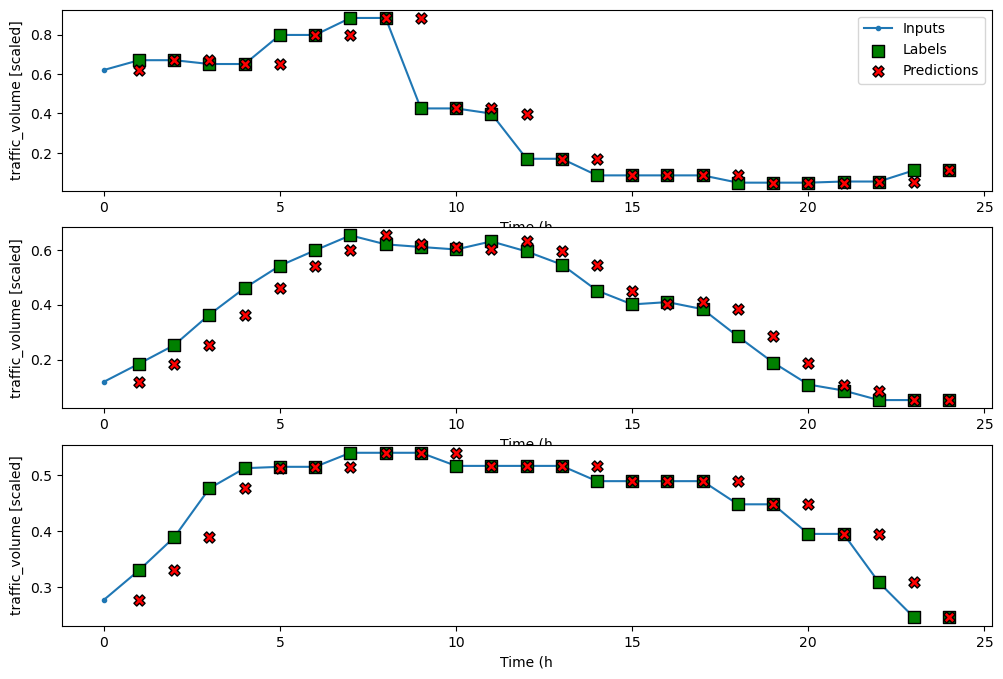

In [263]:
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError

# generate a dict with the name of index of each column

column_indices = {name: i for i, name in enumerate(train_df.columns)}
print('the column indices contain:', column_indices)

# create the model then define the loss function using MAE and MSE

baseline_last = Baseline(label_index=column_indices['traffic_volume'])
baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])   # import the loss and metrics from tensorflow.keras.models

# calculate it by calling the evaluate on the Baseline class, inherited from tf class

val_performance = {}    # dictionary for placeholder
performance = {}        # dictionary for placeholder of the 

val_performance['baseline_last'] = baseline_last.evaluate(single_step_window.val)
performance['baseline_last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

# creating the plot

wide_window.plot(model=baseline_last, plot_col='traffic_volume')

In [245]:
print('MAE and MSE for single-step model:', val_performance, performance)

MAE and MSE for single-step model: {'baseline_last': [0.01055826060473919, 0.06721998006105423]} {'baseline_last': [0.010360067710280418, 0.06668011099100113]}


### # 4.3 Benchmark: Multi-step Baseline Model

In [277]:
# create DataWindow instance for single step baseline model

multi_step_window = DataWindow(input_width=24, 
                               label_width=24, 
                               shift=24,            # shift is 24 because we want to predict 24 timesteps into the future (the window) 
                               train_df=train_df, 
                               val_df=val_df, 
                               test_df=test_df,
                               label_columns=['traffic_volume'])

In [276]:
# create DataWindow for the plotting, using wide_window as the variable name

ms_wide_window = DataWindow(input_width=24,
                            label_width=24,
                            shift=24,
                            train_df=train_df,
                            val_df=val_df,
                            test_df=test_df,
                            label_columns=['traffic_volume'])

2023-05-03 23:51:12.574273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [9641,5]
	 [[{{node Placeholder/_0}}]]
2023-05-03 23:51:12.575144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [9594]
	 [[{{node Placeholder/_8}}]]


300/300 [==============================] - 1s 4ms/step - loss: 0.1811 - mean_absolute_error: 0.3473


2023-05-03 23:51:14.127735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [4821,5]
	 [[{{node Placeholder/_0}}]]
2023-05-03 23:51:14.128453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [4821,5]
	 [[{{node Placeholder/_0}}]]
2023-05-03 23:51:14.899015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [337

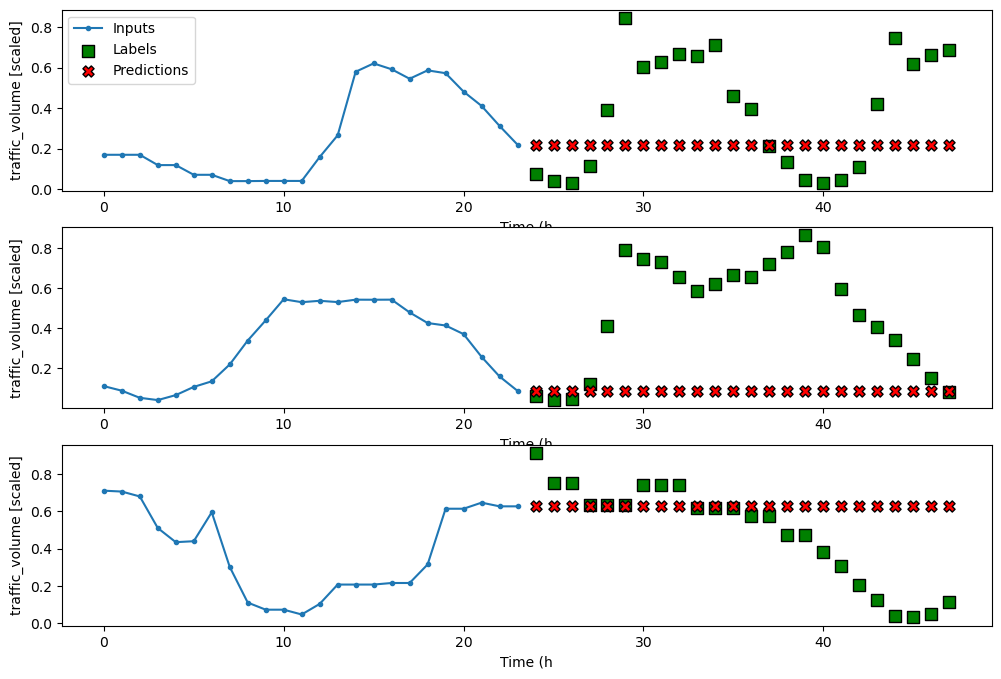

In [278]:
# generate a dict with the name of index of each column
# create the MultiStepLastBaseline() instance

column_indices = {name: i for i, name in enumerate(train_df.columns)}
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['traffic_volume'],
                                         steps=24)

# create the model then define the loss function using MAE and MSE

ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()]),

# calculate it by calling the evaluate on the Baseline class, inherited from tf class

ms_val_performance = {}
ms_performance = {}

ms_val_performance['baseline_last'] = ms_baseline_last.evaluate(multi_step_window.val)
ms_performance['baseline_last'] = ms_baseline_last.evaluate(multi_step_window.test, verbose=0)

# creating the plot

ms_wide_window.plot(model=ms_baseline_last, plot_col='traffic_volume')

In [279]:
print('MAE and MSE for multi-step model:', ms_val_performance, ms_performance)

MAE and MSE for multi-step model: {'baseline_last': [0.18109066784381866, 0.34725144505500793]} {'baseline_last': [0.18449729681015015, 0.3517155349254608]}


### # 4.4 Benchmark: Repeat-step Baseline Model

Simply returns the n input sequence. In other words, let's say if we set the steps to be 24 hours, then the prediction for the next 24 hours will be the last known 24 hours of the data. We can use the DataClass() instance from the previous multistep windows.

2023-05-03 23:51:31.160515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-03 23:51:31.161683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [9594]
	 [[{{node Placeholder/_8}}]]


300/300 [==============================] - 2s 4ms/step - loss: 0.1381 - mean_absolute_error: 0.2864


2023-05-03 23:51:33.286393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-03 23:51:33.287299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [4821,5]
	 [[{{node Placeholder/_0}}]]


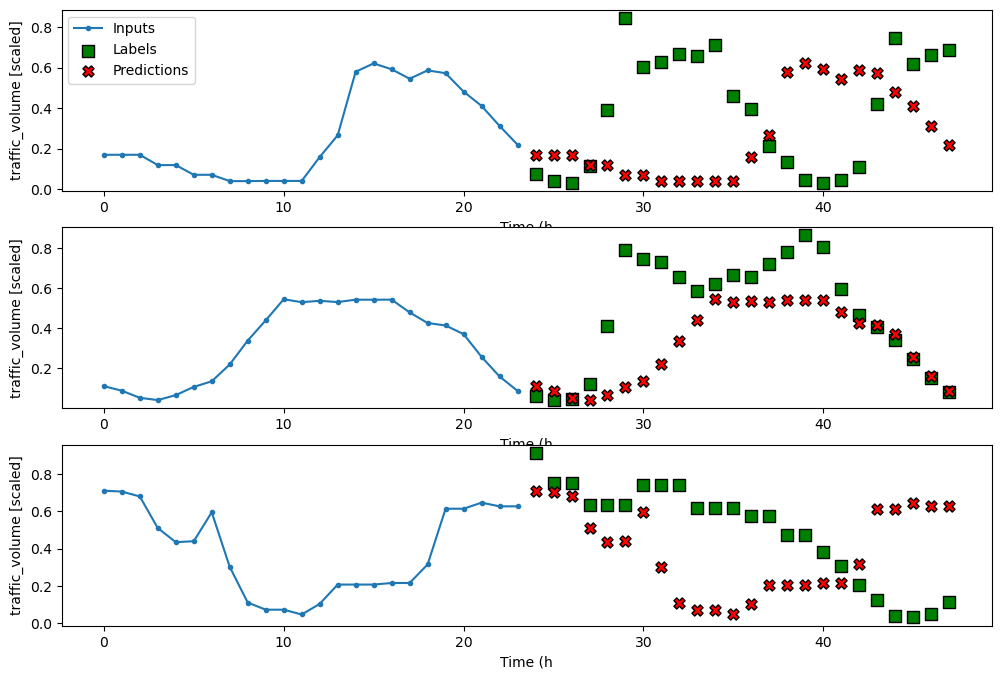

In [280]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['baseline_repeat'] = ms_baseline_repeat.evaluate(multi_step_window.val)
ms_performance['baseline_repeat'] = ms_baseline_repeat.evaluate(multi_step_window.test, verbose=0)

ms_wide_window.plot(model=ms_baseline_repeat, plot_col='traffic_volume')

In [270]:
print('MAE and MSE for multi-step model:', ms_val_performance['baseline_repeat'], ms_performance['baseline_repeat'])

MAE and MSE for multi-step model: [0.13813069462776184, 0.28635847568511963] [0.1460753083229065, 0.2957480847835541]


### # 4.5 Benchmark: Multi-output Baseline Model

Predict two variables at the same time. Using the baseline class that we built before. Here, we're trying to predict **traffic volume** and **temperature** at the same time.

In [344]:
mo_single_step_window = DataWindow(input_width=24,
                                   label_width=24,
                                   shift=1,
                                   train_df=train_df,
                                   val_df=val_df,
                                   test_df=test_df,
                                   label_columns=['temp', 'traffic_volume'])

In [345]:
mo_wide_window = DataWindow(input_width=24,
                            label_width=24,
                            shift=1,
                            train_df=train_df,
                            val_df=val_df,
                            test_df=test_df,
                            label_columns=['temp', 'traffic_volume'])

In [346]:
# check the indices 
# the indices will be passed as one of the parameter for baseline instance

print(column_indices['traffic_volume'], column_indices['temp'])

2 0


2023-05-04 10:36:59.264124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-04 10:36:59.265360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


301/301 [==============================] - 1s 3ms/step - loss: 0.0053 - mean_absolute_error: 0.0346


2023-05-04 10:37:00.639362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-04 10:37:00.640230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-04 10:37:01.121230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-04 10:37

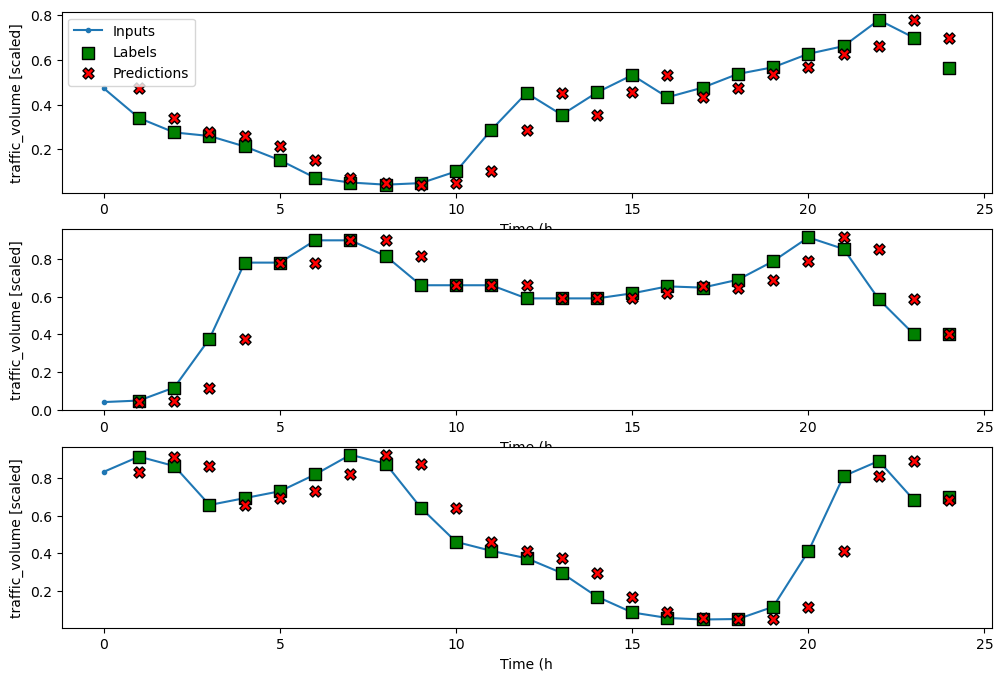

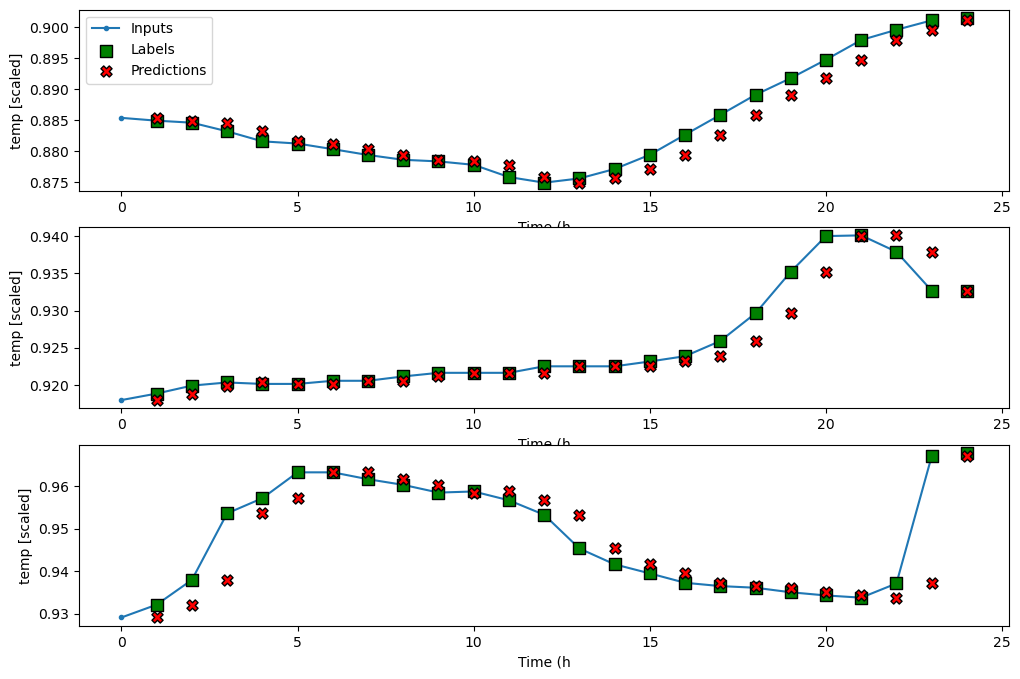

In [347]:
mo_baseline_last = Baseline(label_index=[0,2])

mo_val_performance = {}
mo_performance = {}

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance['baseline_last'] = mo_baseline_last.evaluate(mo_single_step_window.val)
mo_performance['baseline_last'] = mo_baseline_last.evaluate(mo_single_step_window.test, verbose=0)

for col in ['traffic_volume', 'temp']:
    mo_wide_window.plot(model=mo_baseline_last, plot_col=col)

## # 5 Hands-On : Basic Deep Learning Model

1. Create the model instance first
2. Compile and fit the model instance to the compile_and_fit
3. Calculate the performance of the model using evaluate method from tf class
4. Plot it by the wide_window (a DataWindow() instance)

### # 5.1 Class & Functions: Basic Deep Learning Model

In [553]:
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.optimizers import Adam 

def compile_and_fit(model, window, patience=3, max_epochs=50, save_model=False):
    '''
    Function to configure a deep learning, fit it on the data, and train the data.

    Parameters
    ----------
    model : 
        Pass the model from tensorflow.
    window : 
        Pass the DataWindow() instance.
    patience : 
        Number of epochs after which the model should stop training
        if the validation loss doesn't improve.
        Set default at 3.
    max_epochs : 
        Maximum number of epochs to train the model.

    Returns
    -------
    history : 
        The trained model.
    '''
    
    # early stopping to stop the model from training if there's no imporvement in the loss function
    
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    # model compiler, to specify the loss function, optimizer, and the metrics
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    # fitting the model, callbacks to stop it early if the validation loss is not decreased after 3 (default set) consecutive periods
    
    history = model.fit(window.train,
                        epochs=max_epochs,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    
    if save_model == True:
        return model, history
    
    else:
        history

### # 5.2 Single-step Linear Model

    # Create the model instance first, for linear -> using a sequential model without hidden layer (dense(units=1))
    # Compile and fit the model instance to the compile_and_fit

In [319]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

linear = Sequential([
    Dense(units=1)
])

history = compile_and_fit(model=linear, 
                          window=single_step_window)

Epoch 1/50


2023-05-04 10:02:56.026591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [33742,5]
	 [[{{node Placeholder/_0}}]]
2023-05-04 10:02:56.027441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [33718]
	 [[{{node Placeholder/_8}}]]


1029/1054 [============================>.] - ETA: 0s - loss: 0.0744 - mean_absolute_error: 0.2092

2023-05-04 10:02:59.161455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [9617]
	 [[{{node Placeholder/_8}}]]
2023-05-04 10:02:59.162269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [9617]
	 [[{{node Placeholder/_8}}]]


1054/1054 [==============================] - 4s 3ms/step - loss: 0.0733 - mean_absolute_error: 0.2073 - val_loss: 0.0296 - val_mean_absolute_error: 0.1276
Epoch 2/50
1054/1054 [==============================] - 4s 4ms/step - loss: 0.0206 - mean_absolute_error: 0.1043 - val_loss: 0.0129 - val_mean_absolute_error: 0.0853
Epoch 3/50
1054/1054 [==============================] - 3s 3ms/step - loss: 0.0121 - mean_absolute_error: 0.0778 - val_loss: 0.0085 - val_mean_absolute_error: 0.0670
Epoch 4/50
1054/1054 [==============================] - 4s 4ms/step - loss: 0.0105 - mean_absolute_error: 0.0702 - val_loss: 0.0080 - val_mean_absolute_error: 0.0641
Epoch 5/50
1054/1054 [==============================] - 5s 4ms/step - loss: 0.0104 - mean_absolute_error: 0.0692 - val_loss: 0.0079 - val_mean_absolute_error: 0.0636
Epoch 6/50
1054/1054 [==============================] - 3s 3ms/step - loss: 0.0103 - mean_absolute_error: 0.0690 - val_loss: 0.0079 - val_mean_absolute_error: 0.0635
Epoch 7/50
1054

    Calculate the performance of the model using evaluate method from tf class

In [321]:
val_performance['linear'] = linear.evaluate(single_step_window.val)
performance['linear'] = linear.evaluate(single_step_window.test, verbose=0)

 41/301 [===>..........................] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0628

2023-05-04 10:04:24.123386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-04 10:04:24.124143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [9641,5]
	 [[{{node Placeholder/_0}}]]


301/301 [==============================] - 1s 3ms/step - loss: 0.0078 - mean_absolute_error: 0.0626


2023-05-04 10:04:25.055258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [4797]
	 [[{{node Placeholder/_8}}]]
2023-05-04 10:04:25.055862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


In [322]:
print('MAE and MSE for multi-step model:', val_performance['linear'], performance['linear'])

MAE and MSE for multi-step model: [0.007785637862980366, 0.06263577938079834] [0.007565617561340332, 0.061422888189554214]


    # Plot it by the wide_window (a DataWindow instance)

In [323]:
wide_window = DataWindow(input_width=24,
                         label_width=24,
                         shift=1,
                         train_df=train_df,
                         val_df=val_df,
                         test_df=test_df,
                         label_columns=['traffic_volume'])

2023-05-04 10:07:27.467711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [33718]
	 [[{{node Placeholder/_8}}]]
2023-05-04 10:07:27.468311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [33742,5]
	 [[{{node Placeholder/_0}}]]


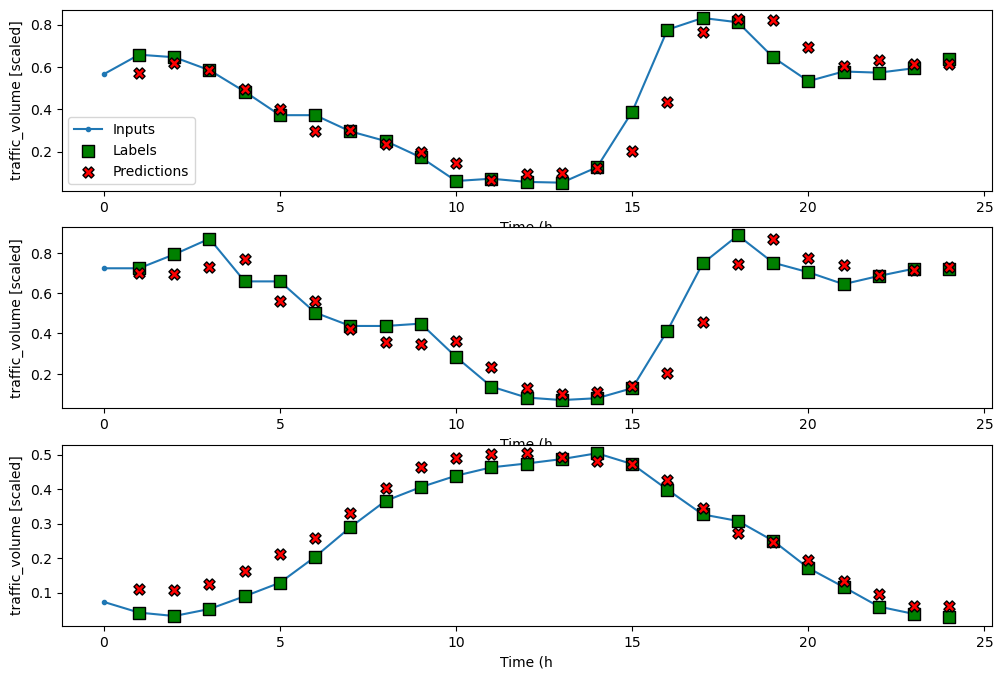

In [325]:
wide_window.plot(model=linear, plot_col='traffic_volume')

### # 5.3 Multi-step Linear Model

In [330]:
ms_linear = Sequential([
    Dense(1, kernel_initializer=tf.keras.initializers.Zeros )
])

history = compile_and_fit(ms_linear, multi_step_window)

Epoch 1/50


2023-05-04 10:17:46.014582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-05-04 10:17:46.015149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [33695]
	 [[{{node Placeholder/_8}}]]


1023/1053 [============================>.] - ETA: 0s - loss: 0.0748 - mean_absolute_error: 0.2265

2023-05-04 10:17:49.709158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-05-04 10:17:49.710989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


1053/1053 [==============================] - 4s 4ms/step - loss: 0.0745 - mean_absolute_error: 0.2261 - val_loss: 0.0598 - val_mean_absolute_error: 0.2034
Epoch 2/50
1053/1053 [==============================] - 4s 4ms/step - loss: 0.0639 - mean_absolute_error: 0.2116 - val_loss: 0.0591 - val_mean_absolute_error: 0.2024
Epoch 3/50
1053/1053 [==============================] - 5s 5ms/step - loss: 0.0638 - mean_absolute_error: 0.2118 - val_loss: 0.0589 - val_mean_absolute_error: 0.2022
Epoch 4/50
1053/1053 [==============================] - 6s 5ms/step - loss: 0.0638 - mean_absolute_error: 0.2119 - val_loss: 0.0589 - val_mean_absolute_error: 0.2026
Epoch 5/50
1053/1053 [==============================] - 3s 3ms/step - loss: 0.0638 - mean_absolute_error: 0.2119 - val_loss: 0.0589 - val_mean_absolute_error: 0.2018
Epoch 6/50
1053/1053 [==============================] - 4s 4ms/step - loss: 0.0638 - mean_absolute_error: 0.2120 - val_loss: 0.0588 - val_mean_absolute_error: 0.2023
Epoch 7/50
1053

In [331]:
ms_val_performance['linear'] = ms_linear.evaluate(multi_step_window.val)
ms_performance['linear'] = ms_linear.evaluate(multi_step_window.test, verbose=0)

 23/300 [=>............................] - ETA: 1s - loss: 0.0585 - mean_absolute_error: 0.2024

2023-05-04 10:22:42.369010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [9641,5]
	 [[{{node Placeholder/_0}}]]
2023-05-04 10:22:42.369686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [9594]
	 [[{{node Placeholder/_8}}]]


300/300 [==============================] - 1s 3ms/step - loss: 0.0589 - mean_absolute_error: 0.2025


2023-05-04 10:22:43.319012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-04 10:22:43.319704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


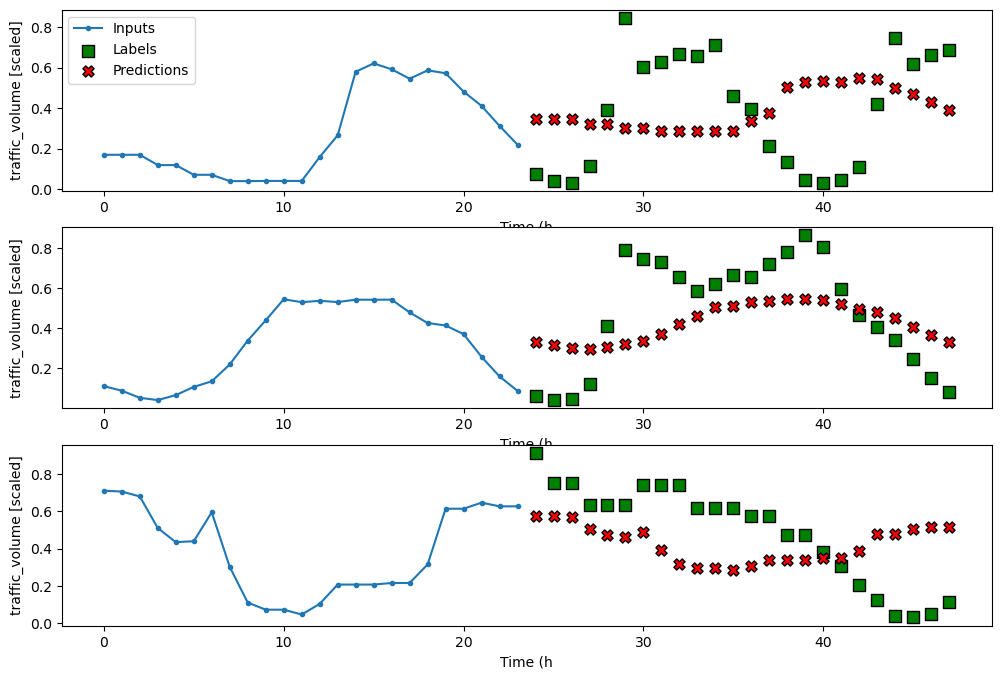

In [333]:
ms_wide_window.plot(model=ms_linear, plot_col='traffic_volume')

In [332]:
print('MAE and MSE for multi-step model:', ms_val_performance['linear'], ms_performance['linear'])

MAE and MSE for multi-step model: [0.05887599661946297, 0.2025112360715866] [0.06091231852769852, 0.2054329812526703]


### # 5.4 Multi-output Linear Model

Epoch 1/50


2023-05-04 10:37:18.721289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [33742,5]
	 [[{{node Placeholder/_0}}]]
2023-05-04 10:37:18.722264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [33718]
	 [[{{node Placeholder/_8}}]]


1035/1054 [============================>.] - ETA: 0s - loss: 0.1680 - mean_absolute_error: 0.3040

2023-05-04 10:37:22.961247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [9641,5]
	 [[{{node Placeholder/_0}}]]
2023-05-04 10:37:22.962070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [9641,5]
	 [[{{node Placeholder/_0}}]]


1054/1054 [==============================] - 5s 4ms/step - loss: 0.1663 - mean_absolute_error: 0.3023 - val_loss: 0.0729 - val_mean_absolute_error: 0.2110
Epoch 2/50
1054/1054 [==============================] - 4s 4ms/step - loss: 0.0408 - mean_absolute_error: 0.1546 - val_loss: 0.0174 - val_mean_absolute_error: 0.1039
Epoch 3/50
1054/1054 [==============================] - 5s 4ms/step - loss: 0.0113 - mean_absolute_error: 0.0782 - val_loss: 0.0063 - val_mean_absolute_error: 0.0584
Epoch 4/50
1054/1054 [==============================] - 5s 5ms/step - loss: 0.0066 - mean_absolute_error: 0.0549 - val_loss: 0.0048 - val_mean_absolute_error: 0.0490
Epoch 5/50
1054/1054 [==============================] - 4s 4ms/step - loss: 0.0059 - mean_absolute_error: 0.0495 - val_loss: 0.0046 - val_mean_absolute_error: 0.0470
Epoch 6/50
1054/1054 [==============================] - 6s 5ms/step - loss: 0.0058 - mean_absolute_error: 0.0481 - val_loss: 0.0045 - val_mean_absolute_error: 0.0463
Epoch 7/50
1054

2023-05-04 10:39:25.332797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [9641,5]
	 [[{{node Placeholder/_0}}]]
2023-05-04 10:39:25.334475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [9641,5]
	 [[{{node Placeholder/_0}}]]


 50/150 [=========>....................] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.0324

2023-05-04 10:39:26.104721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [4821,5]
	 [[{{node Placeholder/_0}}]]
2023-05-04 10:39:26.105746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


150/150 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_absolute_error: 0.0321


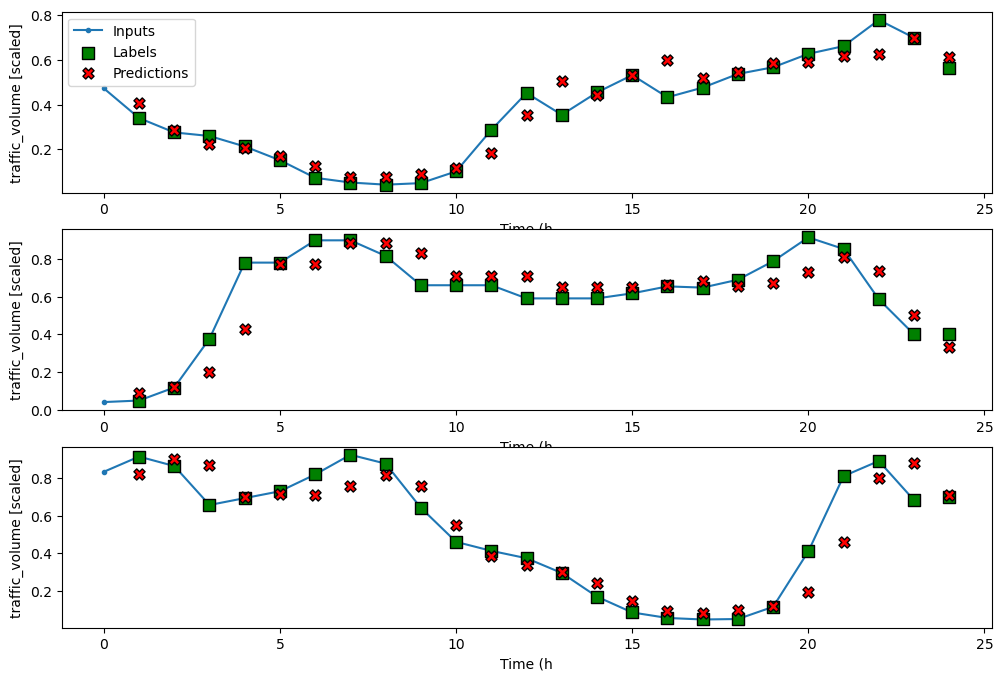

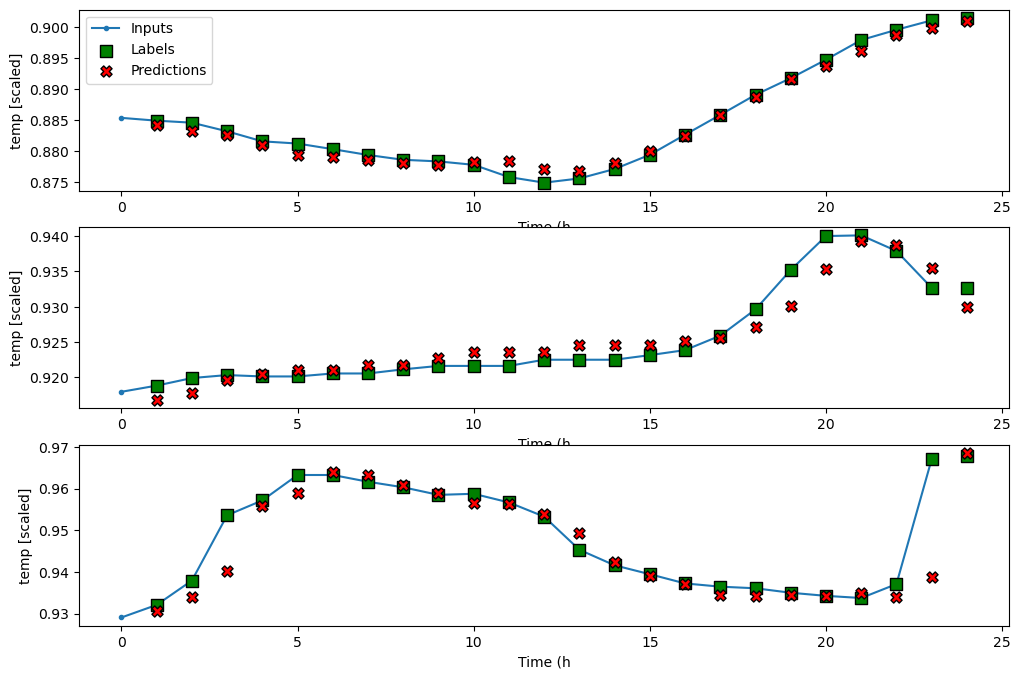

In [349]:
mo_linear = Sequential([
    Dense(units=2)  # set units based by the number of target/output variables
])

history = compile_and_fit(mo_linear, mo_single_step_window)

mo_val_performance['linear'] = mo_linear.evaluate(mo_single_step_window.val)
mo_performance['linear'] = mo_linear.evaluate(mo_single_step_window.test)

for col in ['traffic_volume', 'temp']:
    mo_wide_window.plot(model=mo_linear, plot_col=col)

In [350]:
print('MAE and MSE for multi-step model:', mo_val_performance['linear'], mo_performance['linear'])

MAE and MSE for multi-step model: [0.0038883998058736324, 0.03267766162753105] [0.003787489840760827, 0.03214985504746437]


## # 6 Hands-On : Deep Learning Model with Hidden Layers

The only difference here is that we're employing units in the hidden layers.

### # 6.1 Class and Functions:

Make a plot to turn our previously defined dictionary into a plot.

In [469]:
def plot_loss_compare(dic, labels, **kwargs):
    '''
    Make a plot to turn our previously defined dictionary into a plot. 
    To make a comparison of the loss functions from every model we built.

    Parameters
    ----------
    dic : 
        Pass the dictionary that has been defined before that contains the loss value.
    labels : list
        Pass the label for the barplot, respectively by the order.
    **kwargs:
        Pass the parameteres from pd.DataFrame.plot() method.

    Returns
    -------
    matplotlib.pyplot figure from plt.show()
    '''
    
    # create the bar chart
    fig, ax = plt.subplots()
    temp = pd.DataFrame(dic).T.rename(columns={0:labels[0], 1:labels[1]})
    temp.plot(kind='bar', ax=ax, **kwargs)

    # add annotations to the chart
    for i, row in enumerate(temp.T.values):
        for j, val in enumerate(row):
            ax.text(j + i * 0.2, val, str(round(val, 4)), horizontalalignment='center', verticalalignment='bottom')

    # show the chart and remove the spines
    sns.despine()
    plt.show()

### # 6.2 Single-step Deep Learning with Hidden Layers

    # Define the Model

In [352]:
dense = Sequential([
    Dense(units=64, activation='relu'),     # number of neurons in the first hidden layer
    Dense(units=64, activation='relu'),     # number of neurons in the second hidden layer
    Dense(units=1)                          # output, units should be equal to the number of target variables
])

    # Train the Model and Calculate the Performance of the Model

In [470]:
history = compile_and_fit(dense, single_step_window)

val_performance['dense'] = dense.evaluate(single_step_window.val)
performance['dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50


2023-05-04 12:53:26.365547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [33718]
	 [[{{node Placeholder/_8}}]]
2023-05-04 12:53:26.366453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


1052/1054 [============================>.] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.0411

2023-05-04 12:53:34.006689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-05-04 12:53:34.008105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


1054/1054 [==============================] - 9s 7ms/step - loss: 0.0047 - mean_absolute_error: 0.0411 - val_loss: 0.0029 - val_mean_absolute_error: 0.0366
Epoch 2/50
1054/1054 [==============================] - 7s 7ms/step - loss: 0.0047 - mean_absolute_error: 0.0411 - val_loss: 0.0028 - val_mean_absolute_error: 0.0349
Epoch 3/50
1054/1054 [==============================] - 5s 5ms/step - loss: 0.0047 - mean_absolute_error: 0.0409 - val_loss: 0.0029 - val_mean_absolute_error: 0.0360
Epoch 4/50
1054/1054 [==============================] - 5s 5ms/step - loss: 0.0047 - mean_absolute_error: 0.0409 - val_loss: 0.0030 - val_mean_absolute_error: 0.0382
Epoch 5/50
 25/301 [=>............................] - ETA: 1s - loss: 0.0031 - mean_absolute_error: 0.0364

2023-05-04 12:54:01.433114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [9617]
	 [[{{node Placeholder/_8}}]]
2023-05-04 12:54:01.433850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


301/301 [==============================] - 1s 4ms/step - loss: 0.0030 - mean_absolute_error: 0.0362


2023-05-04 12:54:02.790322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [4821,5]
	 [[{{node Placeholder/_0}}]]
2023-05-04 12:54:02.793992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


    # 3 Make a Plot for It

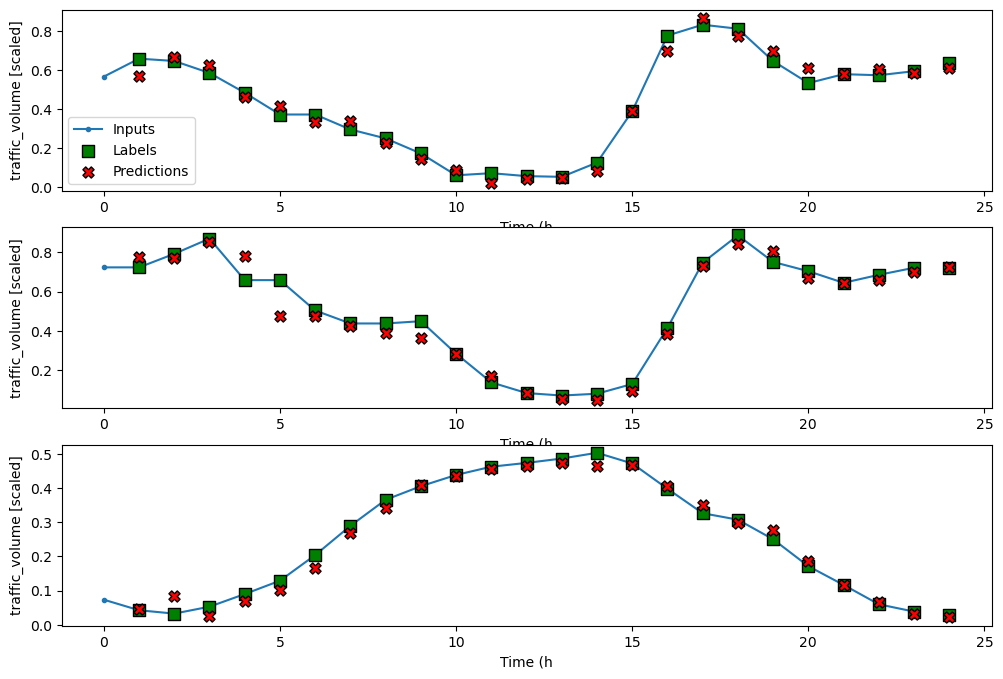

In [471]:
wide_window.plot(model=dense, plot_col='traffic_volume')

    # 4 Now, comparing the performance between baseline, linear, and deep learning with hidden layer model

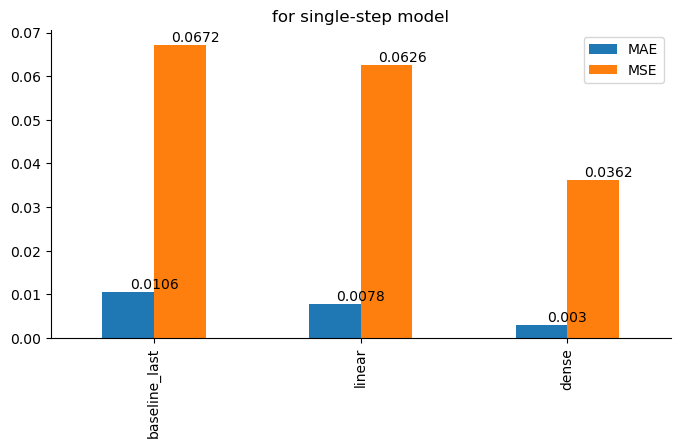

In [472]:
plot_loss_compare(val_performance, figsize=(8,4), labels=['MAE', 'MSE'], title='for single-step model')

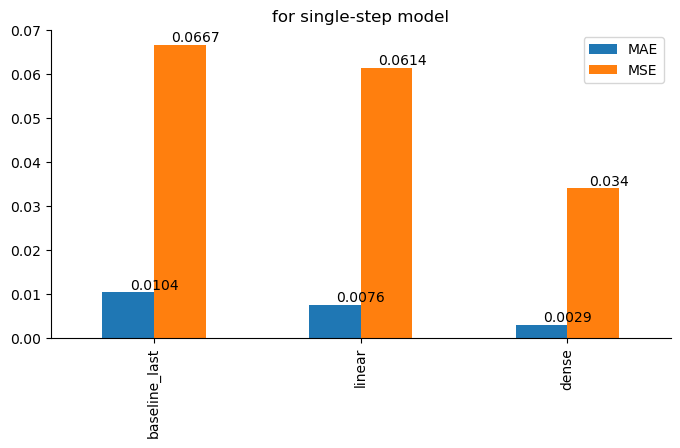

In [473]:
plot_loss_compare(performance, figsize=(8,4), labels=['MAE', 'MSE'], title='for single-step model')

### # 6.3 Multi-step Deep Learning with Hidden Layers

In [451]:
ms_dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(ms_dense, multi_step_window)

Epoch 1/50


2023-05-04 12:46:28.705525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-05-04 12:46:28.706185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [33695]
	 [[{{node Placeholder/_8}}]]


1050/1053 [============================>.] - ETA: 0s - loss: 0.0641 - mean_absolute_error: 0.2094

2023-05-04 12:46:34.536181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [9641,5]
	 [[{{node Placeholder/_0}}]]
2023-05-04 12:46:34.537477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [9641,5]
	 [[{{node Placeholder/_0}}]]


1053/1053 [==============================] - 7s 6ms/step - loss: 0.0641 - mean_absolute_error: 0.2094 - val_loss: 0.0545 - val_mean_absolute_error: 0.1937
Epoch 2/50
1053/1053 [==============================] - 5s 4ms/step - loss: 0.0609 - mean_absolute_error: 0.2051 - val_loss: 0.0542 - val_mean_absolute_error: 0.1919
Epoch 3/50
1053/1053 [==============================] - 6s 5ms/step - loss: 0.0606 - mean_absolute_error: 0.2045 - val_loss: 0.0553 - val_mean_absolute_error: 0.1953
Epoch 4/50
1053/1053 [==============================] - 5s 4ms/step - loss: 0.0606 - mean_absolute_error: 0.2043 - val_loss: 0.0536 - val_mean_absolute_error: 0.1910
Epoch 5/50
1053/1053 [==============================] - 4s 4ms/step - loss: 0.0604 - mean_absolute_error: 0.2038 - val_loss: 0.0542 - val_mean_absolute_error: 0.1918
Epoch 6/50
1053/1053 [==============================] - 6s 6ms/step - loss: 0.0602 - mean_absolute_error: 0.2035 - val_loss: 0.0536 - val_mean_absolute_error: 0.1894
Epoch 7/50
1053

2023-05-04 12:48:25.915878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-05-04 12:48:25.916520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [9641,5]
	 [[{{node Placeholder/_0}}]]


300/300 [==============================] - 1s 3ms/step - loss: 0.0533 - mean_absolute_error: 0.1894


2023-05-04 12:48:27.279638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-05-04 12:48:27.280225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


In [453]:
ms_val_performance['dense'] = ms_dense.evaluate(multi_step_window.val)
ms_performance['dense'] = ms_dense.evaluate(multi_step_window.test, verbose=0)

 31/300 [==>...........................] - ETA: 0s - loss: 0.0538 - mean_absolute_error: 0.1903

2023-05-04 12:50:19.942964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [9594]
	 [[{{node Placeholder/_8}}]]
2023-05-04 12:50:19.943713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [9641,5]
	 [[{{node Placeholder/_0}}]]


300/300 [==============================] - 1s 4ms/step - loss: 0.0533 - mean_absolute_error: 0.1894


2023-05-04 12:50:21.308321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [4821,5]
	 [[{{node Placeholder/_0}}]]
2023-05-04 12:50:21.308942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


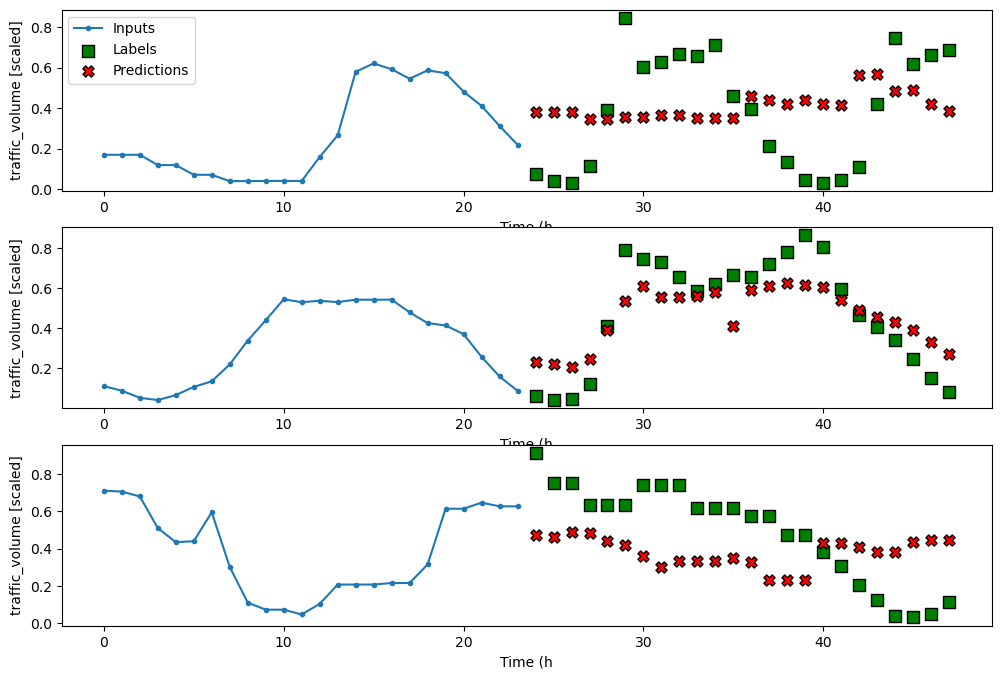

In [454]:
ms_wide_window.plot(model=ms_dense, plot_col='traffic_volume')

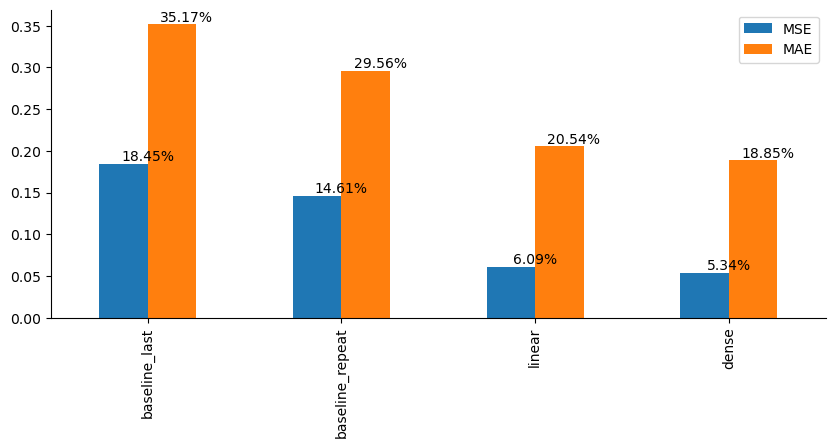

In [458]:
plot_loss_compare(ms_performance, labels=['MSE', 'MAE'], figsize=(10,4))

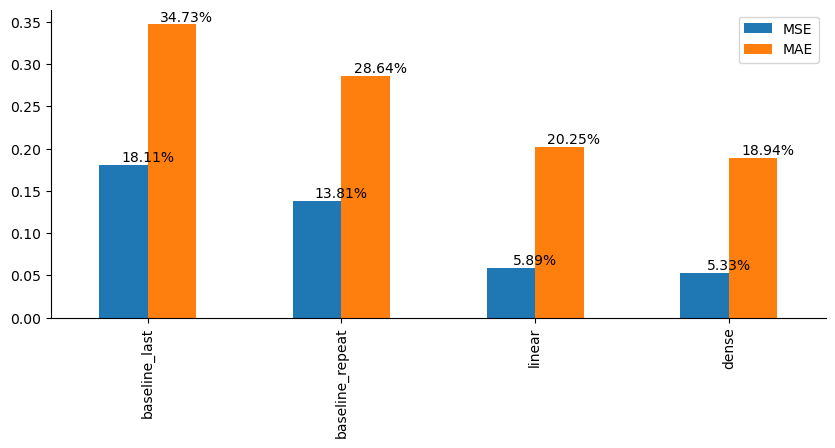

In [459]:
plot_loss_compare(ms_val_performance, labels=['MSE', 'MAE'], figsize=(10,4))

### # 6.4 Multi-Output Deep Learning with Hidden Layers

In [476]:
mo_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=2)  # specify here that we have 2 outputs
])

history = compile_and_fit(mo_dense, mo_single_step_window)

mo_val_performance['dense'] = mo_dense.evaluate(mo_single_step_window.val)
mo_performance['dense'] = mo_dense.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50


2023-05-04 13:02:42.678559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [33742,5]
	 [[{{node Placeholder/_0}}]]
2023-05-04 13:02:42.679508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [33718]
	 [[{{node Placeholder/_8}}]]


1052/1054 [============================>.] - ETA: 0s - loss: 0.0110 - mean_absolute_error: 0.0462

2023-05-04 13:02:50.045640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [9617]
	 [[{{node Placeholder/_8}}]]
2023-05-04 13:02:50.046317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


1054/1054 [==============================] - 8s 5ms/step - loss: 0.0110 - mean_absolute_error: 0.0462 - val_loss: 0.0018 - val_mean_absolute_error: 0.0250
Epoch 2/50
1054/1054 [==============================] - 4s 4ms/step - loss: 0.0026 - mean_absolute_error: 0.0257 - val_loss: 0.0016 - val_mean_absolute_error: 0.0213
Epoch 3/50
1054/1054 [==============================] - 5s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0240 - val_loss: 0.0016 - val_mean_absolute_error: 0.0207
Epoch 4/50
1054/1054 [==============================] - 4s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0235 - val_loss: 0.0015 - val_mean_absolute_error: 0.0195
Epoch 5/50
1054/1054 [==============================] - 5s 5ms/step - loss: 0.0025 - mean_absolute_error: 0.0230 - val_loss: 0.0016 - val_mean_absolute_error: 0.0201
Epoch 6/50
1054/1054 [==============================] - 5s 5ms/step - loss: 0.0025 - mean_absolute_error: 0.0228 - val_loss: 0.0014 - val_mean_absolute_error: 0.0196
Epoch 7/50
1054

2023-05-04 13:03:31.478993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-04 13:03:31.479599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [9641,5]
	 [[{{node Placeholder/_0}}]]


301/301 [==============================] - 1s 3ms/step - loss: 0.0014 - mean_absolute_error: 0.0191


2023-05-04 13:03:32.690323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [4797]
	 [[{{node Placeholder/_8}}]]
2023-05-04 13:03:32.691251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


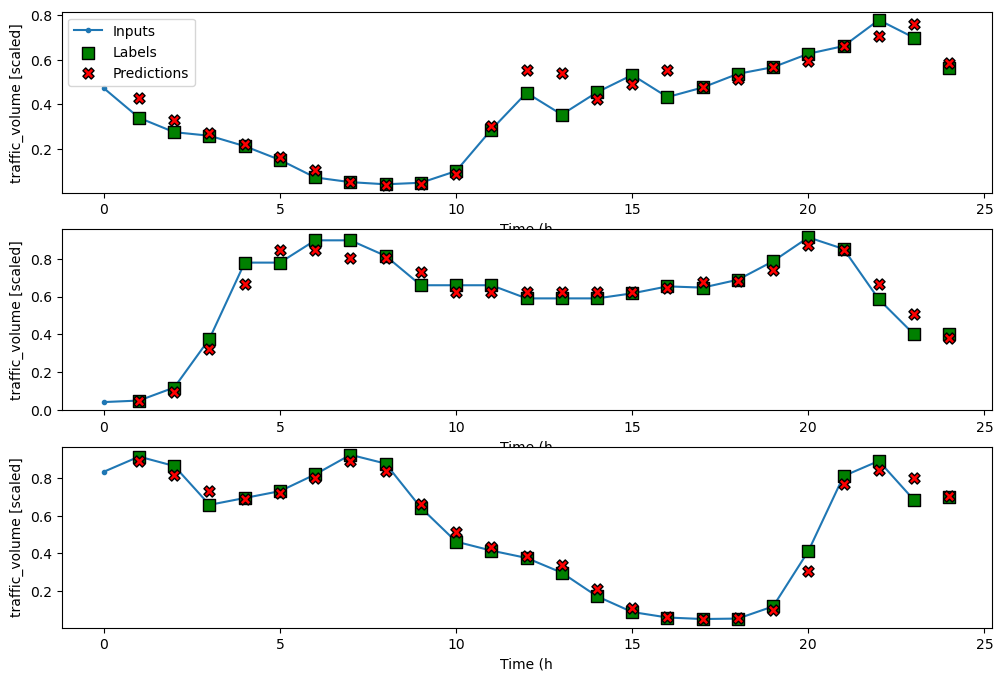

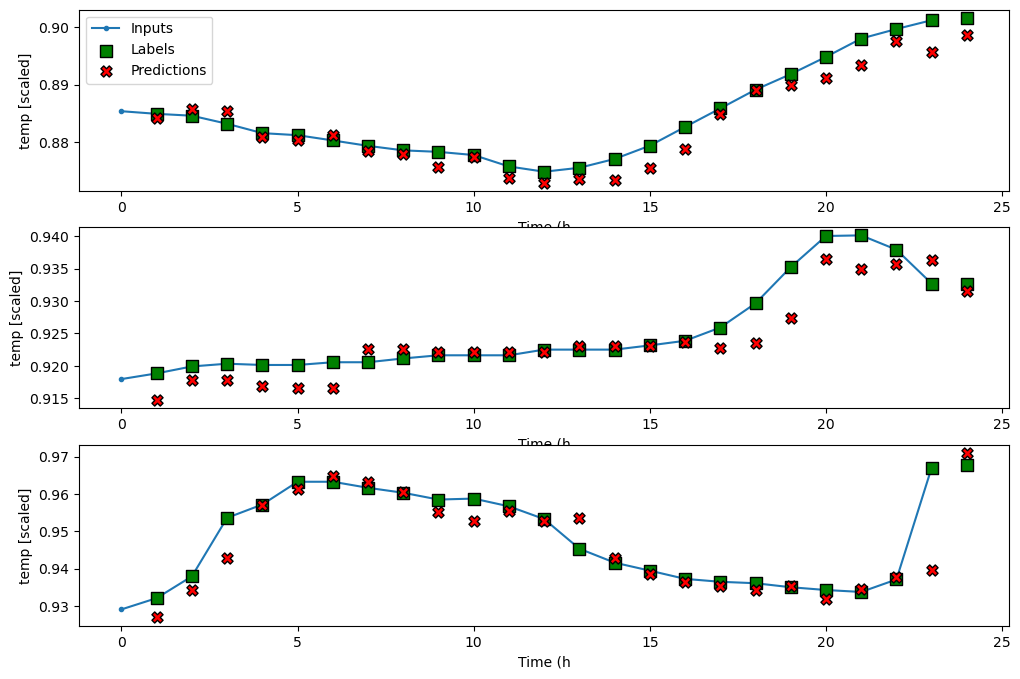

In [477]:
for col in ['traffic_volume', 'temp']:
    mo_wide_window.plot(model=mo_dense, plot_col=col)

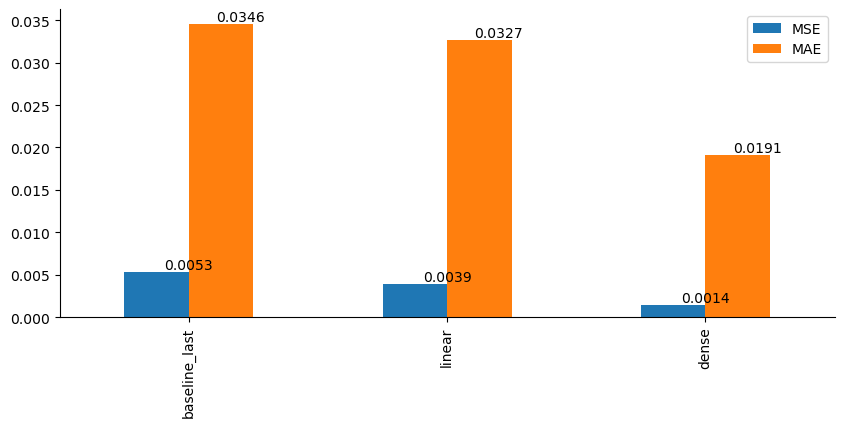

In [481]:
plot_loss_compare(mo_val_performance, labels=['MSE', 'MAE'], figsize=(10,4))

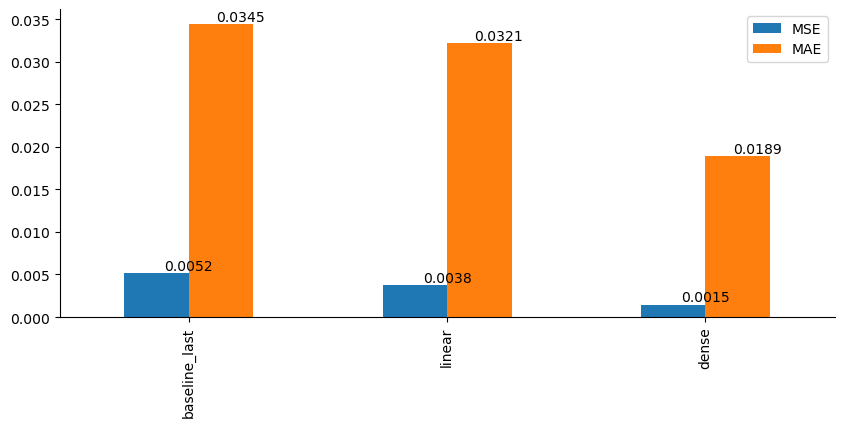

In [482]:
plot_loss_compare(mo_performance, labels=['MSE', 'MAE'], figsize=(10,4))

## # 7 Hands On: Long Short-Term Memory (LSTM) from Recurrent Neural Network (RNN)

- **RNN:** A type of neural network to process sequential data, where the order matters
- **LSTM:** Sub-type of RNN, where it adds a cell state to the RNN architecture to avoid the vanishing gradient problem (short-term memory problem with RNN)

LSTM is built by three gates:

1. Forget gate: Determine what information from **past** steps is still relevant.
2. Input gate: Determine what information from **current** steps is still relevant.
3. Output gate: Determine what **information is passed on to the next element** of the sequence or as a result to the output layer.

### # 7.1 LSTM Single-Step Model

In [485]:
wide_window = DataWindow(input_width=24,
                         label_width=24,
                         shift=1,
                         train_df=train_df,
                         val_df=val_df,
                         test_df=test_df,
                         label_columns=['traffic_volume'])

In [490]:
from tensorflow.keras.layers import LSTM

lstm_model = Sequential([
    LSTM(32, return_sequences=True),  # set return_sequences as true to make it learns from the past network
    Dense(units=1)
])

history = compile_and_fit(lstm_model, single_step_window)

val_performance['lstm'] = lstm_model.evaluate(wide_window.val)
performance['lstm'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50


2023-05-04 15:41:34.869393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-04 15:41:34.871538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [33742,5]
	 [[{{node Placeholder/_0}}]]
2023-05-04 15:41:35.699283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int

1052/1054 [============================>.] - ETA: 0s - loss: 0.0161 - mean_absolute_error: 0.0857

2023-05-04 15:41:54.463227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [9617]
	 [[{{node Placeholder/_8}}]]
2023-05-04 15:41:54.463816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-05-04 15:41:54.680085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32


1054/1054 [==============================] - 21s 15ms/step - loss: 0.0161 - mean_absolute_error: 0.0857 - val_loss: 0.0058 - val_mean_absolute_error: 0.0555
Epoch 2/50
1054/1054 [==============================] - 17s 16ms/step - loss: 0.0080 - mean_absolute_error: 0.0593 - val_loss: 0.0049 - val_mean_absolute_error: 0.0502
Epoch 3/50
1054/1054 [==============================] - 17s 17ms/step - loss: 0.0072 - mean_absolute_error: 0.0561 - val_loss: 0.0043 - val_mean_absolute_error: 0.0474
Epoch 4/50
1054/1054 [==============================] - 15s 15ms/step - loss: 0.0064 - mean_absolute_error: 0.0524 - val_loss: 0.0036 - val_mean_absolute_error: 0.0430
Epoch 5/50
1054/1054 [==============================] - 13s 13ms/step - loss: 0.0058 - mean_absolute_error: 0.0494 - val_loss: 0.0034 - val_mean_absolute_error: 0.0412
Epoch 6/50
1054/1054 [==============================] - 14s 13ms/step - loss: 0.0054 - mean_absolute_error: 0.0475 - val_loss: 0.0032 - val_mean_absolute_error: 0.0410
Epo

2023-05-04 15:47:31.871636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [9641,5]
	 [[{{node Placeholder/_0}}]]
2023-05-04 15:47:31.872315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


301/301 [==============================] - 1s 5ms/step - loss: 0.0025 - mean_absolute_error: 0.0349


2023-05-04 15:47:33.435565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [4797]
	 [[{{node Placeholder/_8}}]]
2023-05-04 15:47:33.436215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


2023-05-04 15:47:46.120597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-04 15:47:46.121242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


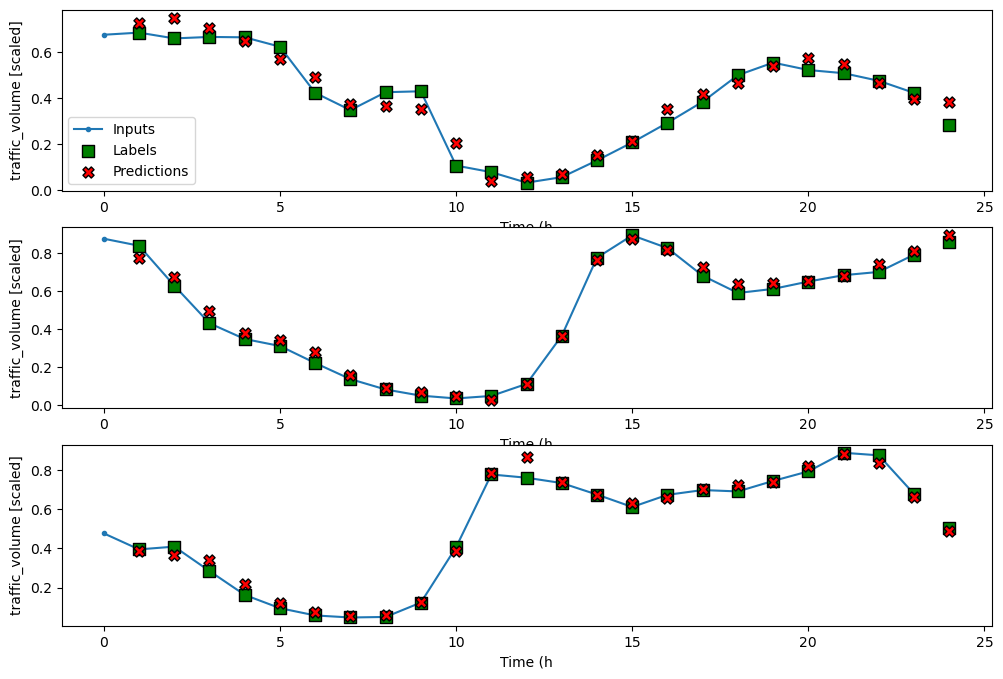

In [491]:
single_step_window.plot(model=lstm_model, plot_col='traffic_volume')

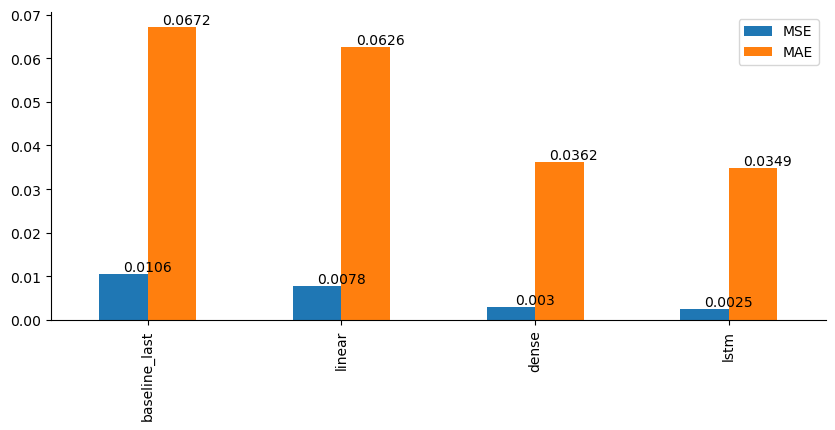

In [495]:
plot_loss_compare(val_performance, labels=['MSE', 'MAE'], figsize=(10,4))

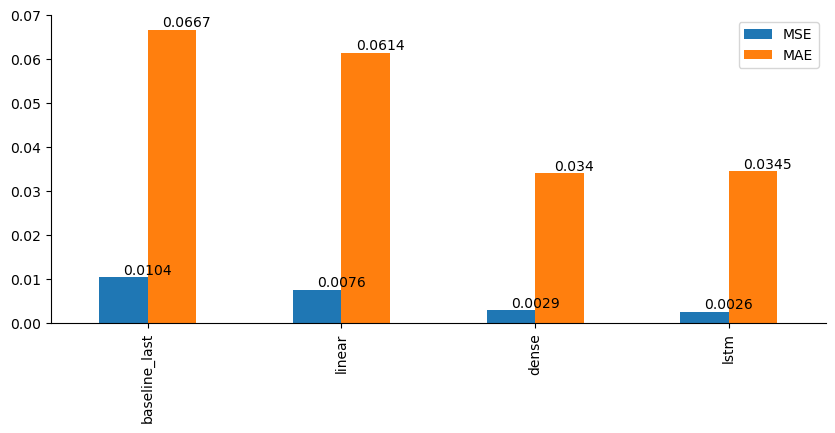

In [496]:
plot_loss_compare(performance, labels=['MSE', 'MAE'], figsize=(10,4))

### 7.2 LSTM Multi-Step Model

In [498]:
ms_lstm_model = Sequential([
    LSTM(32, return_sequences=True),  # set return_sequences as true to make it learns from the past network
    Dense(1, kernel_initializer=tf.initializers.Zeros)
])

history = compile_and_fit(ms_lstm_model, multi_step_window)

ms_val_performance['lstm'] = ms_lstm_model.evaluate(multi_step_window.val)
ms_performance['lstm'] = ms_lstm_model.evaluate(multi_step_window.test, verbose=0)

Epoch 1/50


2023-05-04 15:51:32.414012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [33742,5]
	 [[{{node Placeholder/_0}}]]
2023-05-04 15:51:32.415131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-04 15:51:32.792517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int

1053/1053 [==============================] - ETA: 0s - loss: 0.0682 - mean_absolute_error: 0.2163

2023-05-04 15:51:50.727618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-04 15:51:50.728348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [9594]
	 [[{{node Placeholder/_8}}]]
2023-05-04 15:51:51.298212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32


1053/1053 [==============================] - 21s 17ms/step - loss: 0.0682 - mean_absolute_error: 0.2163 - val_loss: 0.0558 - val_mean_absolute_error: 0.1968
Epoch 2/50
1053/1053 [==============================] - 17s 17ms/step - loss: 0.0611 - mean_absolute_error: 0.2051 - val_loss: 0.0541 - val_mean_absolute_error: 0.1918
Epoch 3/50
1053/1053 [==============================] - 14s 13ms/step - loss: 0.0605 - mean_absolute_error: 0.2035 - val_loss: 0.0544 - val_mean_absolute_error: 0.1938
Epoch 4/50
1053/1053 [==============================] - 11s 11ms/step - loss: 0.0600 - mean_absolute_error: 0.2023 - val_loss: 0.0531 - val_mean_absolute_error: 0.1893
Epoch 5/50
1053/1053 [==============================] - 13s 13ms/step - loss: 0.0594 - mean_absolute_error: 0.2009 - val_loss: 0.0530 - val_mean_absolute_error: 0.1871
Epoch 6/50
1053/1053 [==============================] - 15s 14ms/step - loss: 0.0585 - mean_absolute_error: 0.1989 - val_loss: 0.0525 - val_mean_absolute_error: 0.1858
Epo

2023-05-04 15:56:00.487379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [9641,5]
	 [[{{node Placeholder/_0}}]]
2023-05-04 15:56:00.488250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


300/300 [==============================] - 2s 5ms/step - loss: 0.0981 - mean_absolute_error: 0.2316


2023-05-04 15:56:02.085572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-04 15:56:02.086198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [4821,5]
	 [[{{node Placeholder/_0}}]]


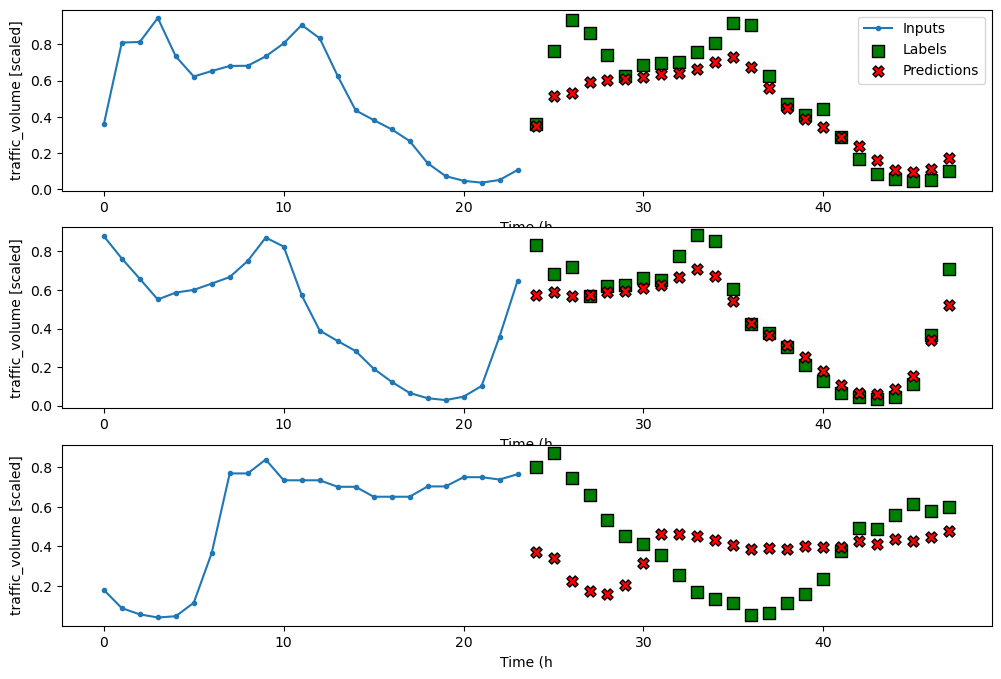

In [503]:
multi_step_window.plot(model=ms_lstm_model, plot_col='traffic_volume')

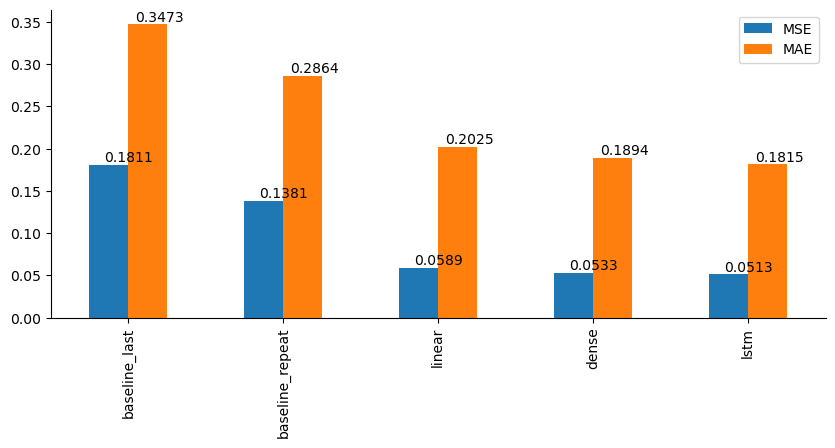

In [504]:
plot_loss_compare(ms_val_performance, labels=['MSE', 'MAE'], figsize=(10,4))

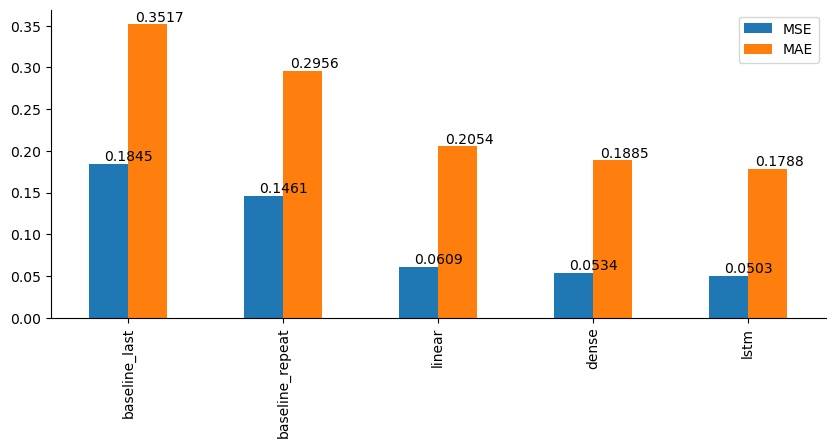

In [505]:
plot_loss_compare(ms_performance, labels=['MSE', 'MAE'], figsize=(10,4))

## # 8 Hands On: Time Series with Convolutional Neural Network (CNN)

Another type of Neural Network which is usually used for image processing. Could be used for Time Series as well. Advantages over RNN:
- Noise resistant and can effectively filter out the noise in the time series with the convolution operation
- CNNs are **faster to train** than LSTMs, can be parallelized

For more details on how it works, check **Page 307** of the book.

### 8.1 CNN as a Single-Step Model

    Little bit discussion about Kernel Width

**output_length = input_length - kernel_length + 1**

We're going to use the kernel length as 3. Thus, we need the input length to be 3 as well. Output length couldn't be 0. Otherwise, there is no data to be passed, processed, and shown as the result.

In [508]:
# DataWindow instance for the model

kernel_width = 3  # could be adjusted later, to refine the result

conv_window = DataWindow(input_width=kernel_width,
                         label_width=1,
                         shift=1,
                         train_df=train_df,
                         val_df=val_df,
                         test_df=test_df,
                         label_columns=['traffic_volume'])

**output_length = input_length - kernel_length + 1** <p>thus, using basic algebra...<p>
**input_length = output_length + kernel_length - 1**

For plotting, we would like to see the predictions of the model over a period of 24 hours. Shift remains 1. Thus, following the formula above, the **input length would be 24 + 3 - 1 = 26.**

In [510]:
# Create data window for plotting

label_width = 24
kernel_width = 3

input_width = label_width + kernel_width - 1

wide_conv_window = DataWindow(input_width=input_width,
                              label_width=label_width,
                              shift=1,
                              train_df=train_df,
                              val_df=val_df,
                              test_df=test_df,
                              label_columns=['traffic_volume'])

In [514]:
# Create the CNN Model

from tensorflow.keras.layers import Conv1D

cnn_model = Sequential([
    Conv1D(filters=32,                  # filters is equal to units in the Dense layers
           kernel_size=(kernel_width),
           activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

history = compile_and_fit(cnn_model, conv_window)

val_performance['cnn'] = cnn_model.evaluate(conv_window.val)
performance['cnn'] = cnn_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50


2023-05-04 17:06:31.605920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [33739]
	 [[{{node Placeholder/_8}}]]
2023-05-04 17:06:31.606995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


1033/1055 [============================>.] - ETA: 0s - loss: 0.0121 - mean_absolute_error: 0.0723

2023-05-04 17:06:35.844877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [9638]
	 [[{{node Placeholder/_8}}]]
2023-05-04 17:06:35.845644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [9638]
	 [[{{node Placeholder/_8}}]]


1055/1055 [==============================] - 5s 4ms/step - loss: 0.0120 - mean_absolute_error: 0.0719 - val_loss: 0.0043 - val_mean_absolute_error: 0.0493
Epoch 2/50
1055/1055 [==============================] - 4s 4ms/step - loss: 0.0063 - mean_absolute_error: 0.0531 - val_loss: 0.0040 - val_mean_absolute_error: 0.0488
Epoch 3/50
1055/1055 [==============================] - 4s 4ms/step - loss: 0.0059 - mean_absolute_error: 0.0505 - val_loss: 0.0036 - val_mean_absolute_error: 0.0428
Epoch 4/50
1055/1055 [==============================] - 4s 4ms/step - loss: 0.0056 - mean_absolute_error: 0.0490 - val_loss: 0.0032 - val_mean_absolute_error: 0.0408
Epoch 5/50
1055/1055 [==============================] - 4s 3ms/step - loss: 0.0055 - mean_absolute_error: 0.0480 - val_loss: 0.0031 - val_mean_absolute_error: 0.0398
Epoch 6/50
1055/1055 [==============================] - 4s 4ms/step - loss: 0.0053 - mean_absolute_error: 0.0471 - val_loss: 0.0030 - val_mean_absolute_error: 0.0387
Epoch 7/50
1055

2023-05-04 17:07:09.732345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [9638]
	 [[{{node Placeholder/_8}}]]
2023-05-04 17:07:09.733297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [9638]
	 [[{{node Placeholder/_8}}]]


302/302 [==============================] - 1s 3ms/step - loss: 0.0035 - mean_absolute_error: 0.0446


2023-05-04 17:07:10.846972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-04 17:07:10.847533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


2023-05-04 17:10:09.492921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-04 17:10:09.494332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [33716]
	 [[{{node Placeholder/_8}}]]


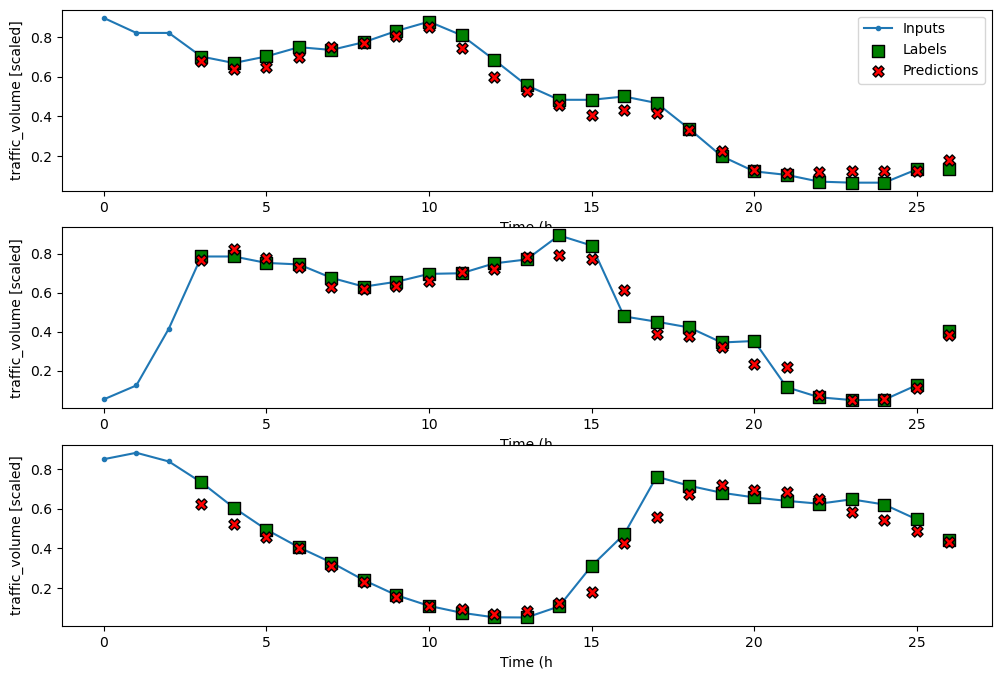

In [516]:
wide_conv_window.plot(model=cnn_model, plot_col='traffic_volume')

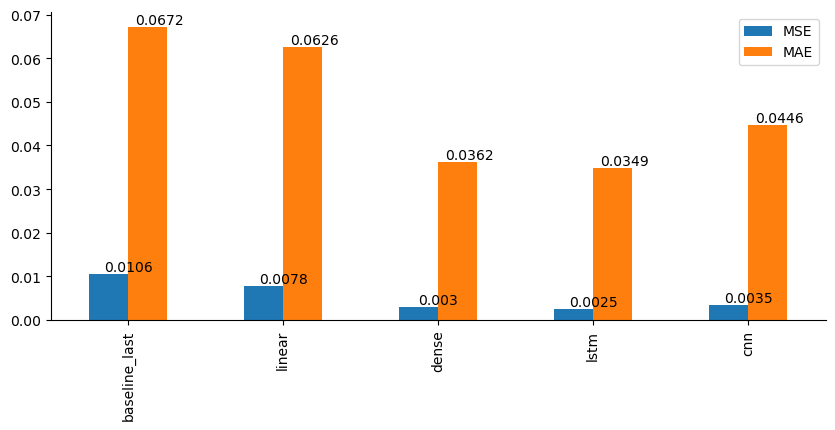

In [517]:
plot_loss_compare(val_performance, labels=['MSE', 'MAE'], figsize=(10,4))

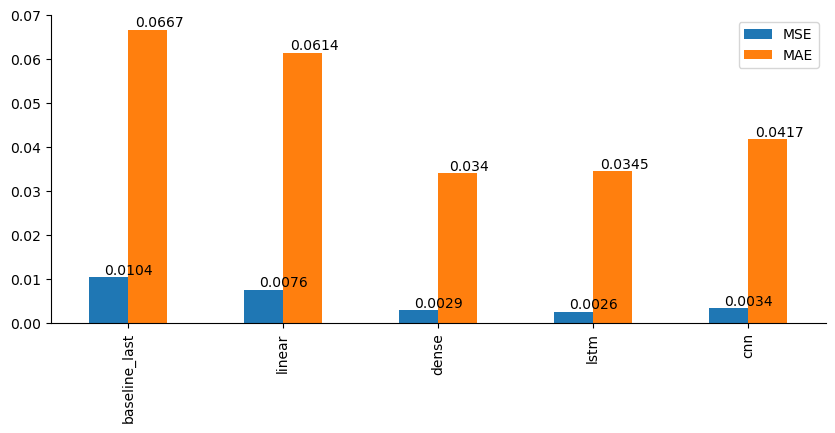

In [518]:
plot_loss_compare(performance, labels=['MSE', 'MAE'], figsize=(10,4))

### 8.2 CNN + LSTM as a Single-Step Model

As the LSTM is still the best performing model, we can actually combine the layer between CNN and LSTM. The step is:
- Filtering the input first from the noises using CNN
- Then using LSTM for processing the data, to the output

In [519]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(kernel_width)),
    LSTM(32, return_sequences=True),  # can play around with how many layers do we want to have
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.Zeros)
])

history = compile_and_fit(cnn_lstm_model, conv_window)

val_performance['cnn_lstm'] = cnn_lstm_model.evaluate(conv_window.val)
performance['cnn_lstm'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

2023-05-04 17:19:41.841603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-04 17:19:41.849538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


Epoch 1/50


2023-05-04 17:19:43.226581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-04 17:19:43.232404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-04 17:19:43.250946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1043/1055 [============================>.] - ETA: 0s - loss: 0.0216 - mean_absolute_error: 0.0922

2023-05-04 17:19:55.609048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [9638]
	 [[{{node Placeholder/_8}}]]
2023-05-04 17:19:55.609969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [9641,5]
	 [[{{node Placeholder/_0}}]]
2023-05-04 17:19:55.868074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

1055/1055 [==============================] - 15s 6ms/step - loss: 0.0214 - mean_absolute_error: 0.0918 - val_loss: 0.0055 - val_mean_absolute_error: 0.0551
Epoch 2/50
1055/1055 [==============================] - 7s 7ms/step - loss: 0.0069 - mean_absolute_error: 0.0566 - val_loss: 0.0045 - val_mean_absolute_error: 0.0508
Epoch 3/50
1055/1055 [==============================] - 9s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0527 - val_loss: 0.0038 - val_mean_absolute_error: 0.0449
Epoch 4/50
1055/1055 [==============================] - 9s 8ms/step - loss: 0.0060 - mean_absolute_error: 0.0509 - val_loss: 0.0037 - val_mean_absolute_error: 0.0437
Epoch 5/50
1055/1055 [==============================] - 9s 8ms/step - loss: 0.0058 - mean_absolute_error: 0.0497 - val_loss: 0.0038 - val_mean_absolute_error: 0.0450
Epoch 6/50
1055/1055 [==============================] - 7s 7ms/step - loss: 0.0057 - mean_absolute_error: 0.0489 - val_loss: 0.0036 - val_mean_absolute_error: 0.0424
Epoch 7/50
105

2023-05-04 17:22:36.429214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-05-04 17:22:36.430585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [9641,5]
	 [[{{node Placeholder/_0}}]]


302/302 [==============================] - 2s 8ms/step - loss: 0.0028 - mean_absolute_error: 0.0370


2023-05-04 17:22:39.138089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [4818]
	 [[{{node Placeholder/_8}}]]
2023-05-04 17:22:39.139450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [4821,5]
	 [[{{node Placeholder/_0}}]]


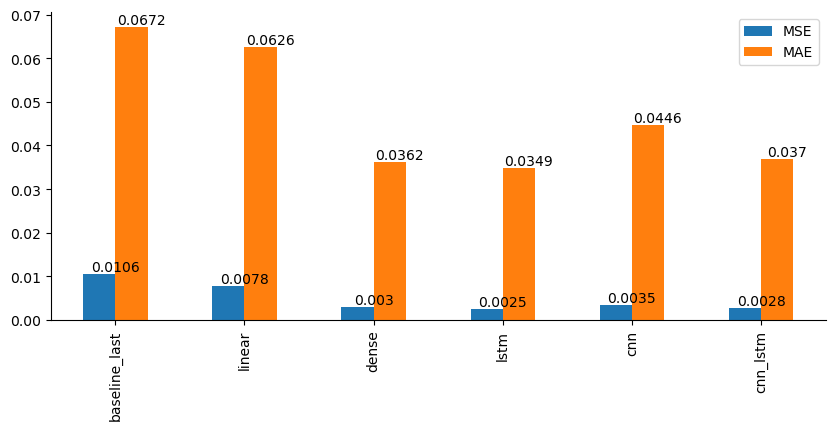

In [522]:
plot_loss_compare(val_performance, labels=['MSE', 'MAE'], figsize=(10,4))

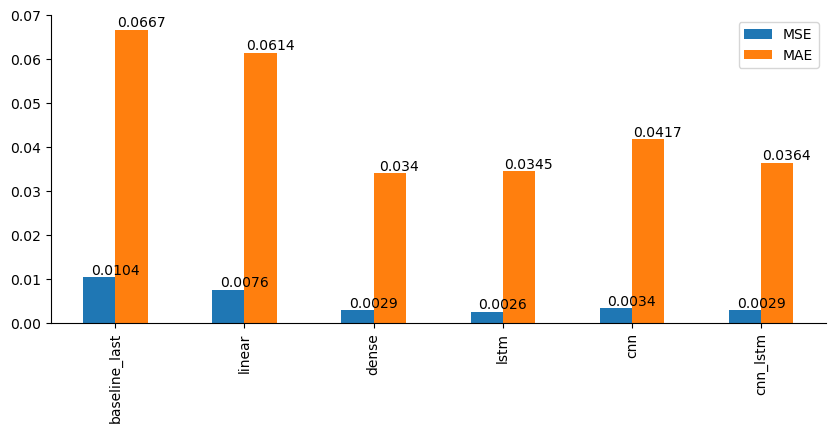

In [523]:
plot_loss_compare(performance, labels=['MSE', 'MAE'], figsize=(10,4))

**For others like CNN for Multi-Step and Multi-Output model, read the book from Page 315 - 318**

## # 9 Auto-Regressive Long Short-Term Memory (ARLSTM)

Using past predictions to make a new prediction. So the way it works will be similar to rolling forecasts, but using its own predictions to inform the output. The steps would be:

1. Predict the one time step ahead
2. Then send this prediction again into the model, allowing to generate the next prediction
3. Sequence is repeadted until we get the desired length

### # 9.1 Class and Functions: Auto-Regressive Model

In [535]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTMCell, RNN, Dense

class AutoRegressive(Model):  # again, inherit the Model method from tf.keras
    '''
    Create, train, and make the prediction of a time-series using 
    Auto-Regressive Long Short-Term Memorty method (ARLSTM).

    Attributes
    ----------
    units : int
        Number of units for the neural networks model layer.
    out_steps : int
        How many n-steps predictions ahead you want to get.
    train_df : pd.DataFrame()
        The training dataframe.

    Methods
    -------
    warmup(inputs):
        Split the window between inputs and labels.
    call(inputs, training=None):
        Plot the input data, prediction, and actual values.
    '''
    
    def __init__(self, units, out_steps, train_df):
        super().__init__()
        self.units = units
        self.out_steps = out_steps
        self.train_df = train_df
        self.lstm_cell = LSTMCell(units)                        # lower level of LSTM layer, to be able to obtain granular details such as state and outputs
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)  # RNN layer wraps the LSTM layer, to make the data raining easier
        self.dense = Dense(train_df.shape[1])                   # the prediction comes from this dense layer
        
    
    def warmup(self, inputs):
        '''
        Replicate the single-step LSTM model, to return
        the first step prediction and its state.

        Attributes
        ----------
        inputs:
            Pass the input.
        
        
        Return
        ------
        The first step of the prediction and the state. 
        '''
        
        # x, *state -> tuple unpacking. takes a tuple or a sequence of values and assigns them to variables in a single statement.
        # so for example if output is (1, 2, 3, 4, 5) -> x = 1 and state = [2, 3, 4, 5]
        x, *state = self.lstm_rnn(inputs)  
        prediction = self.dense(x)
        
        return prediction, state
    
    
    def call(self, inputs, training=None):
        '''
        Loop the prediction and generate the sequence of predictions
        based on the out_steps parameter you define previously.

        Attributes
        ----------
        inputs:
            Pass the input.
        training:
            Parameter for the LSTM cell, inherited from tf.keras
        
        
        Return
        ------
        All the predictions. 
        '''
        
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            
            prediction = self.dense(x)
            predictions.append(prediction)
        
        # related to the data structure of tensorflow
        # see the documentations of the tensoreflow data
        
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])  
        
        return predictions

### # 9.2 Hands On: ARLSTM on Action

1. Built on the multi step window
2. Create the AutoRegressive instance first as the model
3. Then pass this model to the compile and fit function we defined previously
4. Calculate the error of the model, and compare it to the other model

In [538]:
ar_lstm = AutoRegressive(units=32, 
                         out_steps=24, 
                         train_df=train_df)

history = compile_and_fit(ar_lstm, multi_step_window)

ms_val_performance['ar_lstm'] = ar_lstm.evaluate(multi_step_window.val)
ms_performance['ar_lstm'] = ar_lstm.evaluate(multi_step_window.test, verbose=0)

2023-05-05 11:15:35.548114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [33742,5]
	 [[{{node Placeholder/_0}}]]
2023-05-05 11:15:35.549881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [33695]
	 [[{{node Placeholder/_8}}]]


Epoch 1/50
1053/1053 [==============================] - ETA: 0s - loss: 0.0580 - mean_absolute_error: 0.1925

2023-05-05 11:16:04.049982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [9594]
	 [[{{node Placeholder/_8}}]]
2023-05-05 11:16:04.051201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


1053/1053 [==============================] - 32s 21ms/step - loss: 0.0580 - mean_absolute_error: 0.1925 - val_loss: 0.0408 - val_mean_absolute_error: 0.1602
Epoch 2/50
1053/1053 [==============================] - 18s 17ms/step - loss: 0.0456 - mean_absolute_error: 0.1661 - val_loss: 0.0386 - val_mean_absolute_error: 0.1564
Epoch 3/50
1053/1053 [==============================] - 17s 16ms/step - loss: 0.0433 - mean_absolute_error: 0.1602 - val_loss: 0.0370 - val_mean_absolute_error: 0.1451
Epoch 4/50
1053/1053 [==============================] - 18s 17ms/step - loss: 0.0417 - mean_absolute_error: 0.1562 - val_loss: 0.0363 - val_mean_absolute_error: 0.1447
Epoch 5/50
1053/1053 [==============================] - 17s 16ms/step - loss: 0.0409 - mean_absolute_error: 0.1539 - val_loss: 0.0340 - val_mean_absolute_error: 0.1420
Epoch 6/50
1053/1053 [==============================] - 16s 15ms/step - loss: 0.0401 - mean_absolute_error: 0.1518 - val_loss: 0.0333 - val_mean_absolute_error: 0.1393
Epo

2023-05-05 11:23:46.158219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [9641,5]
	 [[{{node Placeholder/_0}}]]
2023-05-05 11:23:46.159927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [9641,5]
	 [[{{node Placeholder/_0}}]]


300/300 [==============================] - 2s 7ms/step - loss: 0.0289 - mean_absolute_error: 0.1239


2023-05-05 11:23:48.492160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [4821,5]
	 [[{{node Placeholder/_0}}]]
2023-05-05 11:23:48.492809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


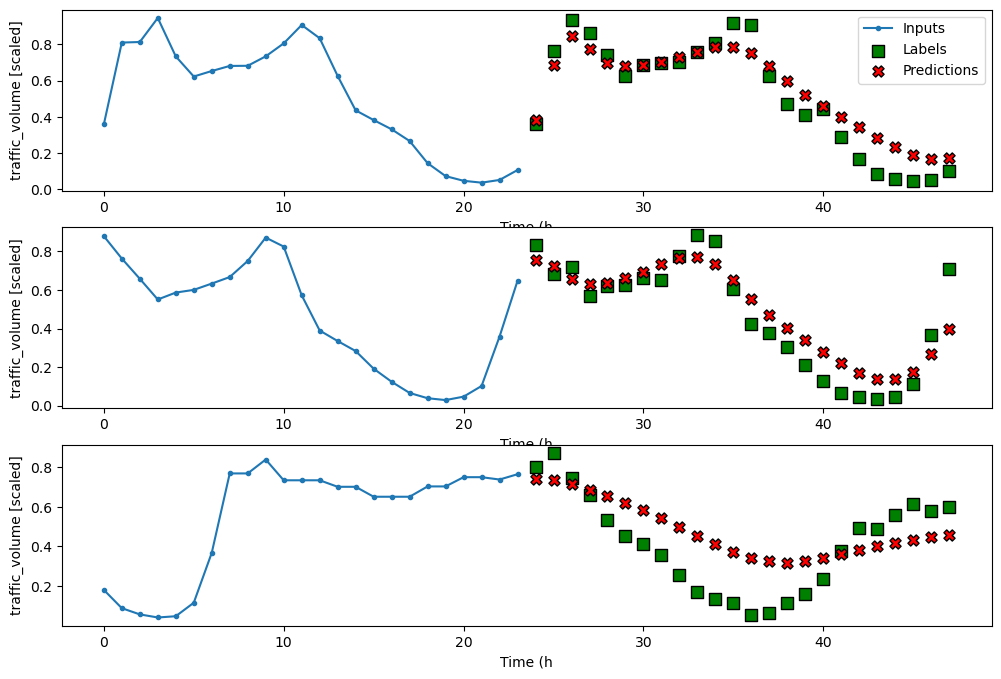

In [539]:
multi_step_window.plot(model=ar_lstm, plot_col='traffic_volume')

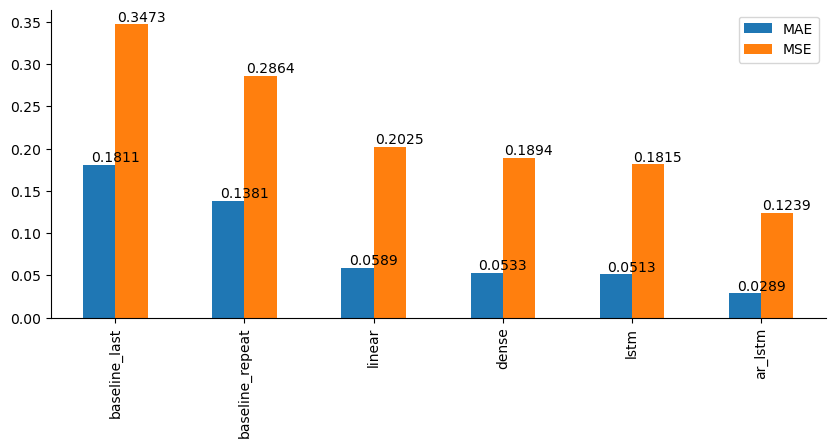

In [543]:
plot_loss_compare(ms_val_performance, labels=['MAE', 'MSE'], figsize=(10,4))

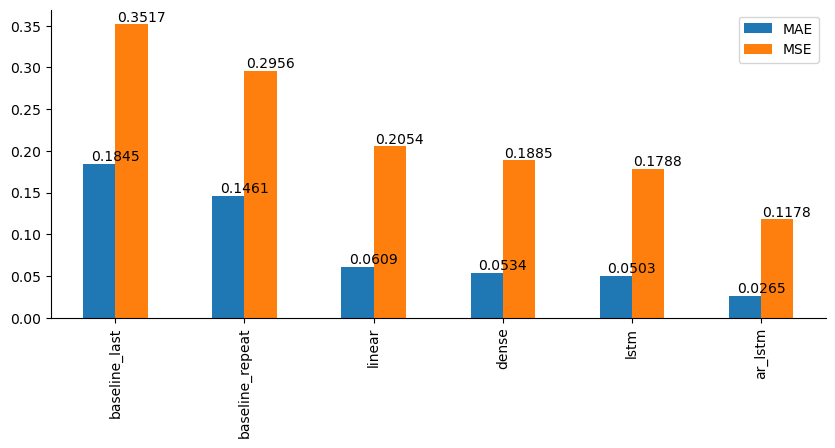

In [544]:
plot_loss_compare(ms_performance, labels=['MAE', 'MSE'], figsize=(10,4))

## # 10 Wrapper, Make the Predictions Based on the Model Chosen

### # 10.1 Class and Functions

In [894]:
def prepare_data_for_prediction(df, window_size, target_column):
    '''
    Prepare dataset for model.predict(). Need to preprocessed first
    as the data is trained on a DataWindow() class object. Thus, this
    function looks very similar to the DataWindow class.

    Attributes
    ----------
    df:
        Dataframe that contains the data we want to predict.
    window_size:
        Window size of the DataWindow() class previously. Not really
        affecting that much if we already know what we're going to do.
        
        
    Return
    ------
    data : array
        Array data which is ready to be passed to the model. Contain either target or predictor variables.
    target :
        Only contains array data for the target variables.
    '''
    
    # get the target column as a separate Series
    target = df[target_column].values

    # create a list to hold the preprocessed windows
    data = []

    # iterate over the DataFrame, creating a window for each row
    for i in range(len(df) - window_size + 1):
        window = df.iloc[i:i + window_size].values
        data.append(window)

    # convert the list of windows to a numpy array
    data = np.array(data)

    # reshape the data to fit the input shape of the model
    data = data.reshape(-1, window_size, df.shape[1])

    return data, target

### # 10.2 Hands On: Make Predictions Based on AR LSTM Model

1. Save the model first into a variable
2. Preprocess the data first into the proper data format to "data" variable
3. Make a prediction based on the preprocessed data
4. Predictions will be quite difficult to understand. 

For the last step, infer it based on:
- DataWindow() instances
- The model that you specify
- Usually, it will be all related to input_width, output_width, and the steps

In [918]:
# make a dummy dataframe first to test
# using previous 24 hours data to predict the next 24 hours traffic volume

pilot_df = df.copy(deep=True)

pilot_df[pilot_df.columns] = scaler.transform(pilot_df[pilot_df.columns])

compare_df = pilot_df[2328:2352].reset_index(drop=True)
pilot_df = pilot_df[2304:2328].reset_index(drop=True)

In [890]:
# save the tf keras model into the model variable

model, history = compile_and_fit(ar_lstm, multi_step_window, save_model=True)

Epoch 1/50


2023-05-05 22:40:18.452380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [33695]
	 [[{{node Placeholder/_8}}]]
2023-05-05 22:40:18.458333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [33742,5]
	 [[{{node Placeholder/_0}}]]


1053/1053 [==============================] - ETA: 0s - loss: 0.0327 - mean_absolute_error: 0.1304

2023-05-05 22:40:45.877373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [9641,5]
	 [[{{node Placeholder/_0}}]]
2023-05-05 22:40:45.878126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [9594]
	 [[{{node Placeholder/_8}}]]


1053/1053 [==============================] - 30s 19ms/step - loss: 0.0327 - mean_absolute_error: 0.1304 - val_loss: 0.0286 - val_mean_absolute_error: 0.1199
Epoch 2/50
1053/1053 [==============================] - 21s 20ms/step - loss: 0.0326 - mean_absolute_error: 0.1302 - val_loss: 0.0287 - val_mean_absolute_error: 0.1234
Epoch 3/50
1053/1053 [==============================] - 20s 19ms/step - loss: 0.0323 - mean_absolute_error: 0.1294 - val_loss: 0.0291 - val_mean_absolute_error: 0.1199
Epoch 4/50
1053/1053 [==============================] - 19s 18ms/step - loss: 0.0322 - mean_absolute_error: 0.1290 - val_loss: 0.0290 - val_mean_absolute_error: 0.1208


In [920]:
# preprocess the data first for the prediction
# pass it into data variable

data, target = prepare_data_for_prediction(pilot_df, 
                                           window_size=24, 
                                           target_column='traffic_volume')

predictions = model.predict(data)

1/1 [==============================] - 0s 64ms/step


In [921]:
# this one is basically on your needs and the model you specify previously
# but for this one, it should be like this

target_column = 'traffic_volume'
target_index = pilot_df.columns.get_loc(target_column)

predictions[:, :, target_index]

array([[0.56697226, 0.5284143 , 0.49280736, 0.45059353, 0.39712387,
        0.3382175 , 0.28270197, 0.2316558 , 0.18397512, 0.14132303,
        0.11028487, 0.10409346, 0.14395976, 0.2541638 , 0.42850378,
        0.57019556, 0.6050257 , 0.58683753, 0.56874096, 0.5644918 ,
        0.57564   , 0.60072374, 0.6352371 , 0.6701598 ]], dtype=float32)

Why? Based on **several reasons:**
- The AR-LSTM model I defined previously used the previous 24 hours data to make a prediction for the next 24 hours data
- The target_index positional slicing is based on the prediction structure from tensorflow keras.

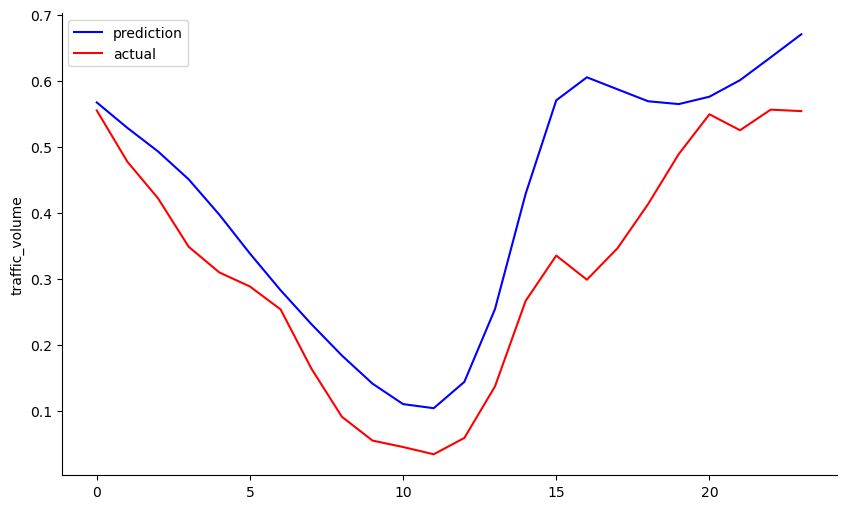

In [922]:
# make the plot
# as a mere of comparison

fig, ax = plt.subplots(figsize=(10,6))

sns.lineplot(x=range(0, 24), y=predictions[:, :, target_index][0], color='blue', label='prediction')
sns.lineplot(x=range(0, 24), y=compare_df['traffic_volume'], color='red', label='actual')

sns.despine()